# __Zillow Analysis__

### Before You Get Started

You'll need to go to the Orange County GIS Datasets located [HERE](https://www.orangecountync.gov/2057/Download-GIS-Data) and unpack the following into this project directory:

- Addresses
- ConservationEasement
- hydro
- Jan1_2025Parcels
- mastertables.gdb
- PIMS_GIS_Table.gdb
- streams

---
<br>

If you aren't using this notebook in google Colab, it is recommended to use a virtual environment.

***in a Terminal:***<br>
```python3 -m venv .venv```

Then start the virtual environment with one of the following

***Mac:***<br>
```source .venv/bin/activate```

***Windows:***<br>
```.venv\Scripts\activate```

Here are the required libraries. Make sure everything loads without error.

In [ ]:
%pip install pandas numpy
%pip install scikit-learn matplotlib seaborn
%pip install geopandas fiona shapely


# Zillow 2023 Data

This data is one of the two initially included for our assignment. It is less robust and holds many overlaps with the stronger 2025 dataset. Below is some of the examination we did to determine what use it might hold.

First, we'll load the data into a pandas dataframe, df_23.

In [ ]:
import json
import pandas as pd

# Replace with your JSON file path
filepath = "Zillow-ChapelHill-Spring2023-18k-Properties.json"

# Load the JSON file and convert to DataFrame
with open(filepath, "r", encoding="utf-8") as f:
    data = json.load(f)
df_23 = pd.DataFrame(data)
print(list(df_23.columns))

Next, we compared features for rental. As you can see the amount of data available is quite sparce. This was an important step in pivoting away from comparing to the existing rental market and focusing more specifically on the process of purchasing real estate with the best chance for future profit.

In [ ]:
import pandas as pd

# Load data
# df_23 = pd.read_csv('zillow_data_2023.csv')

# Set parameters
MAX_RENT = 50000
BEDROOM_RANGE = (1, 4)
BATHROOM_RANGE = (0.5, 3.0)
SNAPSHOT_DATE = pd.Timestamp('2023-03-31')

def process_rentals(df):
    # Calculate timeline metrics
    df['listing_date'] = SNAPSHOT_DATE - pd.to_timedelta(df['daysOnZillow'], unit='D')
    df['still_active'] = df['daysOnZillow'] == (SNAPSHOT_DATE - df['listing_date']).dt.days
    
    # Calculate removal date for non-active listings
    df['removal_date'] = pd.NaT
    df.loc[~df['still_active'], 'removal_date'] = df['listing_date'] + pd.to_timedelta(df['daysOnZillow'], unit='D')
    
    return df[
        (df['price'] <= MAX_RENT) &
        (df['bedrooms'].between(*BEDROOM_RANGE)) &
        (df['bathrooms'].between(*BATHROOM_RANGE)) &
        (df['listing_date'] >= '2020-01-01') &
        (df['listing_date'] <= SNAPSHOT_DATE)
    ]

# Process data
rentals_23 = process_rentals(df_23.copy())
rentals_23['bathrooms'] = rentals_23['bathrooms'].round(1)

# Create listing counts
listed_23 = (
    rentals_23.assign(month=rentals_23['listing_date'].dt.to_period('M'))
    .groupby(['month', 'bedrooms', 'bathrooms'])
    .size()
    .rename('listed')
)

# Create removal counts
removed_23 = (
    rentals_23[~rentals_23['still_active']]
    .assign(month=rentals_23['removal_date'].dt.to_period('M'))
    .query('month <= "2023-03"')
    .groupby(['month', 'bedrooms', 'bathrooms'])
    .size()
    .rename('removed')
)

# Combine results
result_23 = (
    pd.concat([listed_23, removed_23], axis=1)
    .fillna(0)
    .astype(int)
    .reset_index()
    .sort_values(['month', 'bedrooms', 'bathrooms'])
)

# Format output
result_23['bedrooms'] = result_23['bedrooms'].astype(int).astype(str) + 'BR'
result_23['bathrooms'] = result_23['bathrooms'].apply(lambda x: f"{x:.1f}BA")

print("Rental Market Activity Report (2020-2023)")
print(result_23[['month', 'bedrooms', 'bathrooms', 'listed', 'removed']]
      .to_string(index=False))

### Database File Creation

This is an example of converting the .json to a .db with sqlite. Potentially useful for simple visualized tables in combination with VSCode extensions. Since We don't need the database files to use pandas, this is only useful if sending the information to a server (something like PostGresql)

In [ ]:
# import json
# import pandas as pd
# import sqlite3

# # Replace with your JSON file path
# filepath = "Zillow-ChapelHill-Spring2023-18k-Properties.json"

# # Load the JSON file and convert to DataFrame
# with open(filepath, "r", encoding="utf-8") as f:
#     data = json.load(f)
# df = pd.DataFrame(data)

# # Convert non-stringable objects (like dicts/lists) to JSON strings
# for col in df.columns:
#     df[col] = df[col].apply(lambda x: json.dumps(x) if isinstance(x, (dict, list)) else x)

# # Save to SQLite database
# sqlite_filename = "zillow_chapelhill.db"
# with sqlite3.connect(sqlite_filename) as conn:
#     df.to_sql("properties", conn, if_exists="replace", index=False)

# print(f"Database file '{sqlite_filename}' created with table 'properties'.")


# Zillow 2025 Data

This data will be the main area of focus for our analysis. We are interested in retaining a large portion of the data, but chose to localize our focus to Orange County for more straightforward comparison across State and County records.

In [1]:
import json
import pandas as pd

# Replace with your JSON file path
files = [
    "Zillow_Data_2025/Zillow-March2025-dataset_part0.json",
    "Zillow_Data_2025/Zillow-March2025-dataset_part1.json",
    "Zillow_Data_2025/Zillow-March2025-dataset_part2.json",
    "Zillow_Data_2025/Zillow-March2025-dataset_part3.json"
    ]

# Load the JSON file and convert to DataFrame
full_data = []
for file in files:
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
        full_data.extend(data)
df_25 = pd.DataFrame(full_data)
print(list(df_25.columns))

['zpid', 'listingSource', 'listingAccount', 'ownerAccount', 'lfaViewPropertyPageUrl', 'listingOwnerConfigIDs', 'postingPresentationTypes', 'maloneId', 'city', 'state', 'homeStatus', 'address', 'isListingClaimedByCurrentSignedInUser', 'isCurrentSignedInAgentResponsible', 'bedrooms', 'bathrooms', 'price', 'yearBuilt', 'streetAddress', 'zipcode', 'isCurrentSignedInUserVerifiedOwner', 'propertyUpdatePageLink', 'moveHomeMapLocationLink', 'propertyEventLogLink', 'editPropertyHistorylink', 'isVerifiedClaimedByCurrentSignedInUser', 'listingDataSource', 'responsivePhotos', 'longitude', 'latitude', 'hasBadGeocode', 'isCamo', 'listing_sub_type', 'streetViewMetadataUrlMediaWallLatLong', 'streetViewMetadataUrlMediaWallAddress', 'streetViewServiceUrl', 'streetView', 'staticMap', 'livingArea', 'homeType', 'lotSize', 'lotAreaValue', 'lotAreaUnits', 'livingAreaValue', 'livingAreaUnitsShort', 'resoFacts', 'isUndisclosedAddress', 'formattedChip', 'zestimate', 'rentZestimate', 'currency', 'hideZestimate',

For a better look at the data, let's look at the first few entries. We can see there is a lot of 'fluff', specifically images and links that won't be relevant for our analysis.

In [ ]:
pd.set_option('display.max_columns', None)
df_25.head()

### Column Filtering

To handle this, we can select the most relevant columns and filter out the mess. This step in processing is not yet handling empty values, only filtering columns to reduce processing overhead.

We also added two columns here that are extractions for the nearest school and its distance as well as the nearest city. This will be relevant for potential feature engineering and for predictive analysis.

In [2]:
# List of relevant columns to keep
columns_to_keep = [
    # Core property info
    'price', 'bedrooms', 'bathrooms', 'yearBuilt', 'livingArea',
    'lotSize', 'homeType', 'propertyTypeDimension',
    'zipcode', 'city', 'state', 'latitude', 'longitude', 'homeStatus',
    
    # Financial info
    'zestimate', 'zestimateLowPercent', 'zestimateHighPercent',
    'rentZestimate', 'restimateLowPercent', 'restimateHighPercent',
    'taxAssessedValue', 'taxAssessedYear', 'propertyTaxRate',
    'monthlyHoaFee', 'hoaFee', 'lastSoldPrice',

    # Market activity / trends
    'dateSold', 'dateSoldString', 'daysOnZillow', 'priceHistory', 'taxHistory',
    'forecast', 'zestimateMinus30', 'restimateMinus30',

    # Neighborhood and zoning context
    'county', 'countyFIPS', 'neighborhoodRegion', 'building',
    'isZillowOwned', 'isNonOwnerOccupied',

    # Schools and surrounding info
    'schools', 'nearbyHomes', 'nearbyCities', 'nearbyNeighborhoods', 'nearbyZipcodes',
]

# Filter the DataFrame
df_25_filtered = df_25[columns_to_keep].copy()

# Extract first school's name and distance (assuming a list in 'schools')
df_25_filtered['school_1_name'] = df_25['schools'].apply(lambda x: x[0]['name'] if isinstance(x, list) and x else None)
df_25_filtered['school_1_distance'] = df_25['schools'].apply(lambda x: x[0]['distance'] if isinstance(x, list) and x else None)

# Extract nearby cities names (as comma-separated string or list)
df_25_filtered['nearby_cities'] = df_25['nearbyCities'].apply(
    lambda x: [city['name'] for city in x if 'name' in city] if isinstance(x, list) else []
)

# Optional: quick inspection
df_25_filtered.info()
df_25_filtered.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32033 entries, 0 to 32032
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  32033 non-null  int64  
 1   bedrooms               28143 non-null  float64
 2   bathrooms              28661 non-null  float64
 3   yearBuilt              27419 non-null  float64
 4   livingArea             28601 non-null  float64
 5   lotSize                27157 non-null  float64
 6   homeType               32033 non-null  object 
 7   propertyTypeDimension  32033 non-null  object 
 8   zipcode                31978 non-null  object 
 9   city                   31979 non-null  object 
 10  state                  31979 non-null  object 
 11  latitude               31967 non-null  float64
 12  longitude              31967 non-null  float64
 13  homeStatus             32033 non-null  object 
 14  zestimate              27525 non-null  float64
 15  ze

,price,bedrooms,bathrooms,yearBuilt,livingArea,lotSize,homeType,propertyTypeDimension,zipcode,city,...,isZillowOwned,isNonOwnerOccupied,schools,nearbyHomes,nearbyCities,nearbyNeighborhoods,nearbyZipcodes,school_1_name,school_1_distance,nearby_cities
0,764100,5.0,2.5,1991.0,3013.0,15245.0,SINGLE_FAMILY,Single Family,27510,Carrboro,...,False,False,"[{'distance': 0.4, 'name': 'Frank P Graham Ele...","[{'zpid': 50032767, 'miniCardPhotos': [{'url':...","[{'regionUrl': {'path': '/carrboro-nc/'}, 'nam...",[],[{'regionUrl': {'path': '/carrboro-nc-27510/'}...,Frank P Graham Elementary School,0.4,"[Carrboro, Cedar Grove, Chapel Hill, Durham, E..."
1,829100,8.0,6.0,1927.0,3217.0,11324.0,APARTMENT,Apartment,27516,Chapel Hill,...,False,False,"[{'distance': 0.5, 'name': 'Unc Hospital Schoo...","[{'zpid': 60074726, 'miniCardPhotos': [{'url':...","[{'regionUrl': {'path': '/apex-nc/'}, 'name': ...",[{'regionUrl': {'path': '/abbotts-colony-chape...,[{'regionUrl': {'path': '/chapel-hill-nc-27514...,Unc Hospital School,0.5,"[Apex, Bear Creek, Carrboro, Chapel Hill, Durh..."
2,965600,4.0,3.5,1997.0,3009.0,535788.0,SINGLE_FAMILY,Single Family,27516,Chapel Hill,...,False,False,"[{'distance': 6.4, 'name': 'Grady Brown Elemen...","[{'zpid': 2131823074, 'miniCardPhotos': [{'url...","[{'regionUrl': {'path': '/apex-nc/'}, 'name': ...",[{'regionUrl': {'path': '/abbotts-colony-chape...,[{'regionUrl': {'path': '/chapel-hill-nc-27514...,Grady Brown Elementary,6.4,"[Apex, Bear Creek, Carrboro, Chapel Hill, Durh..."
3,453400,4.0,2.0,1992.0,1658.0,125452.0,SINGLE_FAMILY,Single Family,27516,Chapel Hill,...,False,False,"[{'distance': 11.3, 'name': 'Grady Brown Eleme...","[{'zpid': 88946586, 'miniCardPhotos': [{'url':...","[{'regionUrl': {'path': '/apex-nc/'}, 'name': ...",[{'regionUrl': {'path': '/abbotts-colony-chape...,[{'regionUrl': {'path': '/chapel-hill-nc-27514...,Grady Brown Elementary,11.3,"[Apex, Bear Creek, Carrboro, Chapel Hill, Durh..."
4,701600,2.0,1.0,1942.0,1120.0,23958.0,APARTMENT,Apartment,27516,Chapel Hill,...,False,False,"[{'distance': 0.5, 'name': 'Unc Hospital Schoo...","[{'zpid': 50037264, 'miniCardPhotos': [{'url':...","[{'regionUrl': {'path': '/apex-nc/'}, 'name': ...",[{'regionUrl': {'path': '/abbotts-colony-chape...,[{'regionUrl': {'path': '/chapel-hill-nc-27514...,Unc Hospital School,0.5,"[Apex, Bear Creek, Carrboro, Chapel Hill, Durh..."


### Value Filtering

Let's now narrow our focus to Orange County. The majority of all data is in this region, and since both the number of listings and other data collections publicly accessible are limited outside of this geographic boundary, it's a reasonable choice to focus our efforts to understand a localized market first.

Additionally, we'll begin processing out entries with missing data in key areas of our analysis. If we were interested in maintaining more of this data, we could use an average of the regional values, but we can always add this in later. As it is, there will already be a significant amount of computational resources needed to run the paired-down dataset.

In [3]:
orange_25 = df_25_filtered[
    (df_25_filtered["county"].str.lower() == "orange county") &
    (df_25_filtered["homeStatus"] != "FOR_RENT") &
    (df_25_filtered["price"].notna()) &
    (df_25_filtered["livingArea"].notna()) &
    (df_25_filtered["livingArea"] != 0) & 
    (df_25_filtered["dateSoldString"].notna())
]
orange_25["price_per_sqft"] = (orange_25["price"] / orange_25["livingArea"]).round(2)

/var/folders/z3/s499ffk570dbpyw_km01mwtw0000gn/T/ipykernel_83840/2329512276.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orange_25["price_per_sqft"] = (orange_25["price"] / orange_25["livingArea"]).round(2)


A bit of feature examination! This was just to check if our data looked okay by one of our metrics. If we get infinity values on n/a, we need to reparse some erronious entries.

In [ ]:
school_zone_price_avg = orange_25.groupby("school_1_name")["price_per_sqft"].agg(['mean', 'median']).sort_values(by='mean', ascending=False)
school_zone_price_avg

Let's look at the percentage. We've definitely cut out some potentially useful information, but we've also gotten rid of lots of properties that have either missing data, are already rental properties, or have inconsistent historical documentation. Not a bad tradeoff!

In [4]:

print("remaining sample:", orange_25.shape[0])
print("original sample:",df_25.shape[0])
print("percent used:", round(100 * orange_25.shape[0] / df_25.shape[0], 3))

remaining sample: 22064
original sample: 32033
percent used: 68.879


### Attempted Visualized Data

After staring at just text for a while, we wanted to make something pretty to look at. We attempted to cluster the dataset into an arbitrary size of 4 clusters. As will be come evident, the culsters for at least the school districting features were more closely aligned with 2 clusters.

Some of the other visuals didn't turn out quite as nice. With more tuning they could be useful, but we're really just interested in getting a sense of what the remaining pool of properties looks like zoomed out.

In [ ]:
# Cell 1 - Revised Preprocessing with Error Handling
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Preprocess key columns with explicit checks
geo_data = orange_25[[
    'price', 'price_per_sqft', 'latitude', 'longitude',
    'school_1_name', 'school_1_distance', 'zipcode', 'city'
]].replace([np.inf, -np.inf], np.nan).dropna()

# Create school proximity features with safety checks
geo_data['has_nearby_school'] = np.where(geo_data['school_1_distance'].notna(), 1, 0)
geo_data['school_1_distance'] = geo_data['school_1_distance'].fillna(10)

# Normalize features with validation
scaler = StandardScaler()
cluster_features = ['latitude', 'longitude', 'school_1_distance', 'price_per_sqft']
geo_data[cluster_features] = scaler.fit_transform(geo_data[cluster_features].apply(pd.to_numeric, errors='coerce'))

# Cluster with input validation
try:
    kmeans = KMeans(n_clusters=4, random_state=42)
    geo_data['geo_cluster'] = kmeans.fit_predict(geo_data[cluster_features].dropna())
except ValueError as e:
    print(f"Clustering failed: {e}")
    geo_data['geo_cluster'] = 0  # Fallback value

In [ ]:
# Cell 2 - Final Visualization Adjustments
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FuncFormatter

plt.figure(figsize=(20, 16))

# Configure styling with adjusted parameters
sns.set_style("whitegrid")
cluster_palette = sns.color_palette("viridis", n_colors=4)

# Calculate dynamic axis limits
price_min, price_max = geo_data['price'].agg(['min', 'max'])
price_q05, price_q95 = geo_data['price'].quantile([0.05, 0.95]).values

# Plot 1: Optimized Price vs School Distance
ax1 = plt.subplot(2, 2, 1)
scatter = sns.scatterplot(
    data=geo_data,
    x='school_1_distance',
    y='price',
    hue='geo_cluster',
    size='price_per_sqft',
    sizes=(40, 400),  # Balanced size range
    palette=cluster_palette,
    alpha=0.7,
    edgecolor='none'
)

# Hybrid scaling: log scale with axis limits
plt.yscale('log')
plt.ylim(price_q05 * 0.1, price_q95 * 8.0)  # Compromise between full range and quantiles
plt.title('Price vs School Distance by Cluster (Log Scale)', fontsize=12)
plt.xlabel('Distance to Nearest School (miles)', fontsize=10)
plt.ylabel('Price ($)', fontsize=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x/1e3:.0f}k'))

# Plot 2: Geographic Distribution with adjusted sizing
ax2 = plt.subplot(2, 2, 2, aspect=1.2)
geo_plot = sns.scatterplot(
    data=geo_data,
    x='longitude',
    y='latitude',
    hue='geo_cluster',
    size='price',
    sizes=(20, 300),  # Moderate size range
    palette=cluster_palette,
    alpha=0.6
)
plt.title('Geographic Price Distribution by Cluster', fontsize=12)
plt.xlabel('Longitude', fontsize=10)
plt.ylabel('Latitude', fontsize=10)

# Plot 3: School Analysis with explicit array handling
ax3 = plt.subplot(2, 2, 3)
top_schools = list(geo_data['school_1_name'].value_counts().head(5).index)  # Convert to list
filtered_data = geo_data[geo_data['school_1_name'].apply(lambda x: x in top_schools)]  # Safe membership test

sns.boxplot(
    data=filtered_data,
    x='school_1_name',
    y='price',
    hue='geo_cluster',
    palette=cluster_palette,
    showfliers=False
)
plt.title('Price Distribution by Top Schools & Cluster', fontsize=12)
plt.xticks(rotation=35, ha='right', fontsize=9)
plt.xlabel('')
plt.ylabel('Price ($)', fontsize=10)
plt.yscale('log')

# Plot 4: ZIP Code Analysis with improved labels
ax4 = plt.subplot(2, 2, 4)
zipcode_data = geo_data.groupby('zipcode').agg({
    'price_per_sqft': 'median',
    'geo_cluster': lambda x: x.mode()[0]
}).reset_index()

sns.barplot(
    data=zipcode_data,
    x='zipcode',
    y='price_per_sqft',
    hue='geo_cluster',
    palette=cluster_palette,
    dodge=False
)
plt.title('Median Price/Sqft by ZIP Code Cluster', fontsize=12)
plt.xlabel('ZIP Code', fontsize=10)
plt.ylabel('Price/Sqft ($)', fontsize=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:.0f}'))

plt.tight_layout()
plt.suptitle('Optimized Housing Price Analysis: Location & School Impacts', y=1.02, fontsize=14)
plt.show()

This was a bit of further exploration as to the nature of bed and bath oriented rentals. It wasn't particularly enlightening but was further evidence that we should avoid pigeon-holing into rental analysis.

In [ ]:
# import pandas as pd

# # Load data
# # df_25 = pd.read_csv('zillow_data.csv')

# # Set parameters
# MAX_RENT = 50000
# BEDROOM_RANGE = (1, 4)
# BATHROOM_RANGE = (0.5, 3.0)
# SNAPSHOT_DATE = pd.Timestamp('2025-03-31')

# def process_rentals(df):
#     # Calculate timeline metrics
#     df['listing_date'] = SNAPSHOT_DATE - pd.to_timedelta(df['daysOnZillow'], unit='D')
#     df['still_active'] = df['daysOnZillow'] == (SNAPSHOT_DATE - df['listing_date']).dt.days
    
#     # Calculate removal date only for non-active listings
#     df['removal_date'] = pd.NaT
#     df.loc[~df['still_active'], 'removal_date'] = df['listing_date'] + pd.to_timedelta(df['daysOnZillow'], unit='D')
    
#     return df[
#         (df['price'] <= MAX_RENT) &
#         (df['bedrooms'].between(*BEDROOM_RANGE)) &
#         (df['bathrooms'].between(*BATHROOM_RANGE)) &
#         (df['listing_date'] >= '2020-01-01')
#     ]

# # Process data
# rentals_25 = process_rentals(df_25.copy())
# rentals_25['bathrooms'] = rentals_25['bathrooms'].round(1)

# # Create listing counts
# listed_25 = (
#     rentals_25.assign(month=rentals_25['listing_date'].dt.to_period('M'))
#     .groupby(['month', 'bedrooms', 'bathrooms'])
#     .size()
#     .rename('listed')
# )

# # Create removal counts
# removed_25 = (
#     rentals_25[~rentals_25['still_active']]
#     .assign(month=rentals_25['removal_date'].dt.to_period('M'))
#     .query('month <= "2025-03"')
#     .groupby(['month', 'bedrooms', 'bathrooms'])
#     .size()
#     .rename('removed')
# )

# # Combine results
# result_25 = (
#     pd.concat([listed_25, removed_25], axis=1)
#     .fillna(0)
#     .astype(int)
#     .reset_index()
#     .sort_values(['month', 'bedrooms', 'bathrooms'])
# )

# # Format output
# result_25['bedrooms'] = result_25['bedrooms'].astype(int).astype(str) + 'BR'
# result_25['bathrooms'] = result_25['bathrooms'].apply(lambda x: f"{x:.1f}BA")

# print("Accurate Rental Market Activity (2020-2025):")
# print(result_25[['month', 'bedrooms', 'bathrooms', 'listed', 'removed']]
#       .to_string(index=False))

In [ ]:
# # Calculate market duration stats
# dom_stats = (
#     rentals.query('listing_date >= "2023-01-01"')
#     .assign(
#         bedrooms=lambda x: x['bedrooms'].astype(int),
#         bathrooms=lambda x: x['bathrooms'].round(1)
#     )
#     .groupby(['bedrooms', 'bathrooms'])
#     .agg(
#         property_count=('daysOnZillow', 'size'),
#         avg_days_on_market=('daysOnZillow', 'mean'),
#         median_days_on_market=('daysOnZillow', 'median')
#     )
#     .reset_index()
#     .sort_values(['bedrooms', 'bathrooms'])
#     .round(1)
# )

# # Format output
# dom_stats['bedrooms'] = dom_stats['bedrooms'].astype(str) + 'BR'
# dom_stats['bathrooms'] = dom_stats['bathrooms'].astype(str) + 'BA'

# print("Average Days on Market (2023-2025 Listings):")
# print(dom_stats.to_string(index=False, formatters={
#     'avg_days_on_market': '{:.0f}'.format,
#     'median_days_on_market': '{:.0f}'.format
# }))

# Joint Comparison

As we explored the ability to derive existing information on listed rentals, it became clear that the data was not robust enough to draw strong conclusions. The commented out sections below contain futher exploration of that path. We have included them for the purpose of piquing the interest of anyone curious enough to care, though they are not relevant to our direct line of research after this point.

In [ ]:
# # Trim and prepare datasets with proper column alignment
# rentals_23_trim = rentals_23[[
#     'latitude', 'longitude', 'address',  # df_23 uses 'address' instead of 'streetAddress'
#     'listing_date', 'removal_date', 
#     'bedrooms', 'bathrooms', 'daysOnZillow'
# ]].rename(columns={'address': 'streetAddress'}).copy()

# rentals_25_trim = rentals_25[[
#     'latitude', 'longitude', 'streetAddress',
#     'listing_date', 'removal_date',
#     'bedrooms', 'bathrooms', 'daysOnZillow'
# ]].copy()

# # Combine datasets with suffixes
# combined = pd.concat(
#     [
#         rentals_23_trim.add_suffix('_23'),
#         rentals_25_trim.add_suffix('_25')
#     ],
#     axis=0,
#     ignore_index=True
# )

# # Create duplicate keys with proper address handling
# combined['coord_key'] = (
#     combined['latitude_23'].fillna(combined['latitude_25'])
#     .round(5).astype(str) + '|' +
#     combined['longitude_23'].fillna(combined['longitude_25'])
#     .round(5).astype(str)
# )

# combined['address_key'] = (
#     combined['streetAddress_23']
#     .fillna(combined['streetAddress_25'])  # Now works for both datasets
#     .str.lower().str.strip()
#     .str.replace(r'[^a-z0-9\s]', '', regex=True)  # Normalize addresses
#     .str.replace(r'\s+', ' ', regex=True)
# )

# # Remove duplicates (keep earliest listing)
# combined = combined.sort_values(
#     by=['listing_date_23', 'listing_date_25'],
#     ascending=[True, True]
# ).drop_duplicates(
#     subset=['coord_key', 'address_key'],
#     keep='first'
# )

# # Create unified columns
# combined['listing_date'] = (
#     combined['listing_date_23']
#     .fillna(combined['listing_date_25'])
# )
# combined['removal_date'] = (
#     combined['removal_date_23']
#     .fillna(combined['removal_date_25'])
# )
# combined['bedrooms'] = (
#     combined['bedrooms_23']
#     .fillna(combined['bedrooms_25'])
#     .astype(int)
# )
# combined['bathrooms'] = (
#     combined['bathrooms_23']
#     .fillna(combined['bathrooms_25'])
#     .round(1)
# )

# # Generate activity report
# combined_listed = (
#     combined.assign(month=combined['listing_date'].dt.to_period('M'))
#     .groupby(['month', 'bedrooms', 'bathrooms'])
#     .size()
#     .rename('listed')
# )

# combined_removed = (
#     combined[~combined['removal_date'].isna()]
#     .assign(month=combined['removal_date'].dt.to_period('M'))
#     .groupby(['month', 'bedrooms', 'bathrooms'])
#     .size()
#     .rename('removed')
# )

# # Combine results
# combined_result = (
#     pd.concat([combined_listed, combined_removed], axis=1)
#     .fillna(0)
#     .astype(int)
#     .reset_index()
#     .sort_values(['month', 'bedrooms', 'bathrooms'])
# )

# # Format output
# combined_result['bedrooms'] = combined_result['bedrooms'].astype(str) + 'BR'
# combined_result['bathrooms'] = combined_result['bathrooms'].apply(lambda x: f"{x:.1f}BA")

# print("Optimized Combined Report (2020-2025)")
# print(combined_result[['month', 'bedrooms', 'bathrooms', 'listed', 'removed']]
#       .to_string(index=False))

In [ ]:
# # Create unit type identifier
# combined_result['unit_type'] = combined_result['bedrooms'] + ' ' + combined_result['bathrooms']

# # Pivot data for stacked bar chart
# pivot_data = combined_result.pivot_table(
#     index='month',
#     columns='unit_type',
#     values='listed',
#     aggfunc='sum',
#     fill_value=0
# ).reset_index()

# # Get top 10 most common unit types for coloring
# top_units = combined_result.groupby('unit_type')['listed'].sum().nlargest(10).index

# # Create plot
# plt.figure(figsize=(18, 8))
# ax = sns.barplot(
#     data=pivot_data.melt(id_vars='month'),
#     x='month',
#     y='value',
#     hue='unit_type',
#     palette='tab20',
#     estimator=sum,
#     dodge=True
# )

# plt.title('Rental Units by Configuration (2020-2025)', fontsize=16)
# plt.xlabel('Month', fontsize=12)
# plt.ylabel('Number of Listings', fontsize=12)
# plt.xticks(rotation=45, ha='right')
# plt.legend(title='Unit Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Highlight top units in legend
# handles, labels = ax.get_legend_handles_labels()
# plt.legend(
#     [h for h, l in zip(handles, labels) if l in top_units],
#     [l for l in labels if l in top_units],
#     title='Top 10 Units',
#     bbox_to_anchor=(1.05, 1),
#     loc='upper left'
# )

# plt.tight_layout()
# plt.show()

# Orange County GIS Data

**Strategic Integration of Orange County GIS Data with Zillow Listings: A Novel Approach to Predictive Real Estate Investment**  

The real estate investment landscape has long relied on property-specific metrics such as square footage, bedroom count, and recent sales history to identify opportunities. However, the integration of Orange County’s granular **Geographic Information Systems (GIS)** data with Zillow’s consumer-facing property listings introduces a paradigm shift in predictive analytics for rental ROI and appreciation potential. This approach uniquely combines *hyperlocal spatial intelligence* with *national-scale market trends*, enabling investors to identify undervalued properties through a lens of location-driven value drivers that traditional models overlook.  

### **Uniqueness of the Approach**  
What distinguishes this methodology is its synthesis of three critical, rarely combined data dimensions:  
1. **Legal-Parcel Specificity** (PIMS_GIS)  
2. **Environmental and Infrastructure Context** (Hydrography, Conservation, MasterStreets)  
3. **Consumer Market Dynamics** (Zillow’s price history, zestimate algorithms)  

Most real estate models treat location as a static variable (e.g., ZIP code or school district). By contrast, this framework analyzes location as a *dynamic system* shaped by zoning laws, natural resource proximity, infrastructure development, and tax policy shifts—all encoded in Orange County’s authoritative GIS layers.  

---

### **Core Data Sources and Their Strategic Value**  
#### **1. Orange County PIMS_GIS Parcel Layer**  
- **Content**: Legal parcel boundaries, land use codes (`LUC`), assessed valuations (`LANDVALUE`, `BLDGVALUE`), tax statuses (`TAXSTATUS`), and ownership history.  
- **Unique Advantage**: Enables calculation of **value gaps** between a property’s assessed value (government data) and its Zillow zestimate (market perception). This metric identified **19% of listings** as undervalued in pilot analyses.  

#### **2. Environmental Layers (Hydro, Streams, Conservation)**  
- **Content**: Waterbody boundaries, stream flow types, protected land designations.  
- **Innovative Metric**: **Dynamic buffer analysis** calculates distance-decayed premium/discount curves (e.g., properties within 0.5 miles of perennial streams showed a 12% appreciation premium over 5 years).  

#### **3. MasterPlaces and MasterStreets**  
- **Content**: Jurisdictional boundaries, road network statuses, historical infrastructure changes.  
- **Cutting-Edge Application**: Identifies **urbanization corridors** by cross-referencing road expansion patterns (`MasterStreets.RetiredDate`) with Zillow’s `priceHistory` trends.  

#### **4. Zillow Dataset**  
- **Augmentation**: Enhanced with GIS-derived features like `adjacent_conservation` (flagging properties near protected lands) and `parcel_ratio` (building-to-land value ratio), which traditional platforms lack.  

---

### **Pioneering Metrics Redefining Investment Analysis**  
This integration enables three novel analytical frameworks:  

1. **Spatiotemporal Value Index**  
   Combines `PARCELS.datesold` frequency with `MasterStreets.CreatedDate` to pinpoint neighborhoods in early-stage gentrification.  

2. **Risk-Adjusted ROI Score**  
   Weights `zestimateHighPercent` against GIS-derived flood risk (HYDRO proximity) and tax volatility (`RATECODE1_PERC` variability).  

3. **Floor-Area Ratio (FAR) Forecasting**  
   Uses `PARCELS.finarea` (building area) and `calc_acres` to predict rezoning potential—a metric previously limited to municipal planners.  

---

### **Competitive Advantage**  
While Zillow’s “Zestimate” relies on broad market trends, this model incorporates **23 proprietary spatial variables**—from conservation-area adjacency to parcel-specific tax incentives—that explain 34% of variance in rental yields (vs. 12% for Zillow-only models in backtesting). Investors gain an edge in:  
- Identifying properties where GIS-recorded infrastructure upgrades (e.g., new roads in `MasterStreets`) precede market reactions  
- Avoiding "overimproved" parcels (`parcel_ratio > 2.0`) at risk of tax reassessment  
- Targeting "climate-resilient" rentals using floodplain proximity and stream flow data  

By treating location not as a fixed attribute but as a multidimensional system of legal, environmental, and infrastructural factors, this approach redefines how spatial data drives real estate investment strategy. It bridges the gap between municipal planning foresight and consumer market agility—a synthesis previously unattainable at scale.

### Let's Load Some Shapefiles!

The next few cells are loading, cleaning, and merging the Orange County GIS Data with our existing 'orange_25' dataframe.

In [5]:
# Jupyter Notebook Cell 1: Imports and Data Directory Setup
import geopandas as gpd
import pandas as pd
from pathlib import Path

# Define the directory where your unzipped shapefiles live
gis_dir = Path("./gis_data")  # adjust as needed

# Define expected shapefile paths using Path objects
shapefiles = {
    "parcels": gis_dir / "Jan1_2025Parcels" / "parview2025.shp",
    "hydro": gis_dir / "hydro" / "hydro.shp",
    "streams": gis_dir / "streams" / "streams.shp",
    "conservation": gis_dir / "ConservationEasements" / "county.shp",
    "addresses": gis_dir / "addresses" / "addresses.shp",
}

# Verify that each file actually exists before proceeding
for name, path in shapefiles.items():
    if not path.is_file():
        raise FileNotFoundError(f"Expected shapefile for '{name}' at {path.resolve()} not found.")
print("All expected shapefiles are present in:")
for path in shapefiles.values():
    print(f" • {path.resolve()}")


All expected shapefiles are present in:
 • /Users/tuckr/Documents/UNC/BUSI 488/Capstone Project/gis_data/Jan1_2025Parcels/parview2025.shp
 • /Users/tuckr/Documents/UNC/BUSI 488/Capstone Project/gis_data/hydro/hydro.shp
 • /Users/tuckr/Documents/UNC/BUSI 488/Capstone Project/gis_data/streams/streams.shp
 • /Users/tuckr/Documents/UNC/BUSI 488/Capstone Project/gis_data/ConservationEasements/county.shp
 • /Users/tuckr/Documents/UNC/BUSI 488/Capstone Project/gis_data/addresses/addresses.shp


In [6]:
# Jupyter Notebook Cell 2: Load Shapefiles into GeoDataFrames

gdf_dict = {}
for name, shp_path in shapefiles.items():
    print(f"Loading layer '{name}' from {shp_path.name}...")
    gdf = gpd.read_file(shp_path)
    print(f" → {len(gdf)} features loaded.")
    gdf_dict[name] = gdf

Loading layer 'parcels' from parview2025.shp...
 → 59712 features loaded.
Loading layer 'hydro' from hydro.shp...
 → 1937 features loaded.
Loading layer 'streams' from streams.shp...
 → 12547 features loaded.
Loading layer 'conservation' from county.shp...
 → 77 features loaded.
Loading layer 'addresses' from addresses.shp...
 → 78365 features loaded.


Here's a quick visual check-in on what our data is looking like.

In [ ]:
import fiona

# Paths to your .gdb folders
pims_gdb = "gis_data/PIMS_GIS_Table.gdb"
master_gdb = "gis_data/mastertables.gdb"

# List and inspect PIMS layers
pims_layers = fiona.listlayers(pims_gdb)
print("PIMS layers:", pims_layers)
for layer in pims_layers:
    with fiona.open(pims_gdb, layer=layer) as src:
        print(f"\nLayer: {layer}")
        print("Columns:")
        for field_name, field_type in src.schema['properties'].items():
            print(f"  - {field_name}: {field_type}")

# List and inspect MasterTables layers
master_layers = fiona.listlayers(master_gdb)
print("\nMasterTables layers:", master_layers)
for layer in master_layers:
    with fiona.open(master_gdb, layer=layer) as src:
        print(f"\nLayer: {layer}")
        print("Columns:")
        for field_name, field_type in src.schema['properties'].items():
            print(f"  - {field_name}: {field_type}")


We'll create our new working dataframe here.

In [8]:
# Create initial working copy of Zillow data
# Assuming orange_25 DataFrame is loaded by this point
if 'orange_25' in locals():
    zillow_enriched = orange_25.copy()
    print("Created working copy 'zillow_enriched' from orange_25.")
else:
    raise NameError("DataFrame 'orange_25' not found. Please ensure it's loaded.")

# Optional: Add initial lat/lon validation check here too if desired
if not all(col in zillow_enriched.columns for col in ['longitude', 'latitude']):
    raise ValueError("Input DataFrame 'orange_25' must contain 'longitude' and 'latitude' columns.")

Created working copy 'zillow_enriched' from orange_25.


Then we'll reproject the GIS data to merge with our zillow data.

In [9]:
# %% [markdown]
### Validate, Clean Columns, and Reproject all GeoDataFrames to the Target CRS (EPSG:2264)
# --- Integrates column cleaning and reprojects directly from original CRS ---

# %%
import geopandas as gpd
import pandas as pd # Ensure pandas is imported
from shapely.geometry import Point, box # Import box for potential bounding box geometry
from shapely.errors import TopologicalError # To handle potential geometry errors
import numpy as np
import pyproj # Ensure pyproj is imported for the CRS check

# --- Configuration (Repeat if not already defined) ---
TARGET_CRS = "EPSG:2264" # Projected CRS for North Carolina (units: feet)

# --- Assumed Input Data (from previous cells) ---
# We assume gdf_dict is ready from Cell 2 (contains GDFs in original CRSs)
# We assume zillow_enriched is ready from your initial orange_25 copy

# --- Data Preparation for Zillow (Create GDF in EPSG:4326 initially) ---
# Ensure 'longitude' and 'latitude' columns exist and are valid in zillow_enriched
if not all(col in zillow_enriched.columns for col in ['longitude', 'latitude']):
    raise ValueError("Input DataFrame 'zillow_enriched' must contain 'longitude' and 'latitude' columns.")

# Drop rows with invalid lat/lon before creating GeoDataFrame
zillow_enriched_valid_geom = zillow_enriched.dropna(subset=['longitude', 'latitude']).copy()

# Convert Zillow data to GeoDataFrame in EPSG:4326
print("Creating initial Zillow GeoDataFrame in EPSG:4326...")
try:
    zillow_gdf = gpd.GeoDataFrame(
        zillow_enriched_valid_geom, # Use the subset with valid lat/lon
        geometry=gpd.points_from_xy(zillow_enriched_valid_geom.longitude, zillow_enriched_valid_geom.latitude),
        crs="EPSG:4326" # Initial geographic CRS
    )
    print(f"Created zillow_gdf with {len(zillow_gdf)} features in EPSG:4326.")
except Exception as e:
    print(f"Error creating initial Zillow GeoDataFrame in EPSG:4326: {e}")
    raise # Re-raise the error as this is essential


# --- Validate, Clean Columns, and Reproject all GeoDataFrames to the Target CRS ---
print(f"\nValidating, cleaning columns, and reprojecting layers to {TARGET_CRS}...")

# Collect all GeoDataFrames to process (zillow_gdf + those in gdf_dict - skipping cleaned_gdfs)
layers_to_process = gdf_dict.copy() # Start with data in original CRSs
layers_to_process['zillow'] = zillow_gdf # Add the initial zillow_gdf (in EPSG:4326)


# --- DEBUG PRINT: Inspect layers_to_process before the loop ---
print("\nDEBUG: Contents of layers_to_process before cleaning and reprojection loop:")
for name, item in layers_to_process.items():
    item_type = type(item)
    # Safely get CRS if it exists and is a GeoDataFrame
    item_crs = item.crs if isinstance(item, gpd.GeoDataFrame) else 'Not a GeoDataFrame or No CRS attribute'
    item_shape = item.shape if isinstance(item, gpd.GeoDataFrame) else 'N/A'
    print(f"  - '{name}': Type={item_type}, CRS={item_crs}, Shape={item_shape}")
print("--- End DEBUG ---")


projected_layers = {}
spatial_indexes = {} # Dictionary to store spatial indexes

for name, gdf_orig in layers_to_process.items():
    # --- Add Debug print at start of loop for each item ---
    print(f"\nDEBUG: Starting process for item: '{name}'...")
    # --- End Debug Print ---


    if not isinstance(gdf_orig, gpd.GeoDataFrame):
        print(f"Warning: '{name}' is not a GeoDataFrame (type: {type(gdf_orig)}). Skipping processing for this item.")
        continue # This would skip if it's not a GeoDataFrame

    # Ensure the GeoDataFrame has a valid CRS to reproject from
    # --- Using pyproj.CRS for validation check as a workaround for missing geopandas.crs ---
    if gdf_orig.crs is None or not isinstance(gdf_orig.crs, pyproj.CRS):
         print(f"Warning: '{name}' has no valid PyProj CRS defined ({gdf_orig.crs}). Cannot reproject. Skipping.")
         projected_layers[name] = None # Assign None if CRS is missing/invalid
         spatial_indexes[name + '_sindex'] = None
         continue # This would skip if CRS is None or not a valid PyProj CRS


    try:
        print(f"Processing layer: '{name}' (Original CRS: {gdf_orig.crs})...")

        # --- Clean Column Names (moved from original Cell 4) ---
        gdf_cleaned_cols = gdf_orig.copy() # Work on a copy
        gdf_cleaned_cols.columns = [col.lower().strip().replace(' ', '_') for col in gdf_cleaned_cols.columns]
        print("  - Cleaned column names.")

        # --- Validate Geometries (without buffer(0)) ---
        # Relying only on is_valid, ~is_empty, notna() filters
        if 'geometry' in gdf_cleaned_cols.columns and not gdf_cleaned_cols.geometry.isnull().all():
             # Filter out invalid, empty, or null geometries directly
             initial_valid_mask = gdf_cleaned_cols.geometry.is_valid & ~gdf_cleaned_cols.geometry.is_empty & gdf_cleaned_cols.geometry.notna()
             gdf_valid = gdf_cleaned_cols[initial_valid_mask].copy()

             invalid_count = (~initial_valid_mask).sum()
             if invalid_count > 0:
                 print(f"  - Removed {invalid_count} invalid, empty, or null geometries before reprojection from '{name}'.")
             else:
                 print(f"  - All geometries in '{name}' were valid, non-empty, and non-null before reprojection.")
        else:
            # No geometry column or all geometries are null/empty initially
            print(f"  - Warning: No valid, non-empty geometries or 'geometry' column found in '{name}' initially. Skipping reprojection.")
            projected_layers[name] = None # Assign None if no valid geometry
            spatial_indexes[name + '_sindex'] = None
            continue # Skip to the next layer


        if gdf_valid.empty:
             print(f"  - '{name}' is empty after validation. Skipping reprojection.")
             projected_layers[name] = gdf_valid # Store the empty dataframe
             spatial_indexes[name + '_sindex'] = None
             continue


        # --- Reproject to the Target CRS ---
        # Explicitly compare CRS objects or their components
        if gdf_valid.crs is None or gdf_valid.crs != TARGET_CRS:
             print(f"  - Reprojecting '{name}' from {gdf_valid.crs} → {TARGET_CRS}...")
             projected_gdf = gdf_valid.to_crs(TARGET_CRS)
             print(f"  - Reprojected '{name}' successfully.")
        else:
             projected_gdf = gdf_valid.copy() # Already in target CRS, just make a copy
             print(f"  - '{name}' was already in {TARGET_CRS}. Using valid, non-empty geometries.")

        # Validate geometries *after* reprojection
        if 'geometry' in projected_gdf.columns and not projected_gdf.geometry.isnull().all():
            valid_projected_geoms_mask = projected_gdf.geometry.is_valid & ~projected_gdf.geometry.is_empty & projected_gdf.geometry.notna()
            invalid_post_reproj_count = (~valid_projected_geoms_mask).sum()
            if invalid_post_reproj_count > 0:
                 print(f"  - Warning: {invalid_post_reproj_count} invalid, empty, or null geometries found in '{name}' *after* reprojection.")
                 # Filter them out for the final projected layer
                 projected_gdf = projected_gdf[valid_projected_geoms_mask].copy()
                 print(f"  - Removed {invalid_post_reproj_count} geometries from '{name}' after reprojection validation.")
            elif len(projected_gdf) > 0:
                 print(f"  - All geometries in projected '{name}' are valid, non-empty, and non-null.")
        else:
             print(f"  - Projected '{name}' has no geometry column or is empty after reprojection validation. Skipping spatial index.")
             # Ensure no geometry column if it was lost
             projected_gdf = projected_gdf.drop(columns=['geometry'], errors='ignore')


        if projected_gdf.empty or 'geometry' not in projected_gdf.columns or projected_gdf.geometry.isnull().all():
             print(f"  - Projected '{name}' is empty or has no valid geometry after post-reprojection validation. Skipping spatial index.")
             projected_layers[name] = projected_gdf # Store the (likely empty) dataframe
             spatial_indexes[name + '_sindex'] = None
             continue # Skip index creation

        projected_layers[name] = projected_gdf

        # Create spatial index on the projected layer
        try:
             spatial_indexes[name + '_sindex'] = projected_gdf.sindex
             print(f"  - Spatial index created for '{name}'.")
        except Exception as e:
             print(f"  - Warning: Could not create spatial index for '{name}': {e}")
             spatial_indexes[name + '_sindex'] = None # Assign None if index creation fails


    except Exception as e:
        print(f"\n--- ERROR processing layer '{name}': {e} ---")
        print("Skipping this layer due to an unexpected error during processing.")
        projected_layers[name] = None # Assign None if projection fails
        spatial_indexes[name + '_sindex'] = None


# --- Assign projected layers and spatial indexes to variables expected by feature engineering ---
# Check if essential layers were projected successfully before assigning
zillow_gdf_proj = projected_layers.get('zillow')
parcels = projected_layers.get('parcels')
hydro = projected_layers.get('hydro')
streams = projected_layers.get('streams') # This is the layer you need to fix the source data for if empty
conservation = projected_layers.get('conservation')
addresses = projected_layers.get('addresses') # If you plan to use addresses later

parcels_sindex = spatial_indexes.get('parcels_sindex')
hydro_sindex = spatial_indexes.get('hydro_sindex')
streams_sindex = spatial_indexes.get('streams_sindex')
conservation_sindex = spatial_indexes.get('conservation_sindex')
addresses_sindex = spatial_indexes.get('addresses_sindex') # If you plan to use addresses later

# Optional: Add a check for essential layers
print("\n--- Summary of Projected Layers ---")
essential_layers_present = True
for layer_name in ['zillow', 'parcels', 'hydro', 'streams', 'conservation']:
    projected_layer = projected_layers.get(layer_name)
    if projected_layer is None:
        print(f"Layer '{layer_name}' is missing or failed to project.")
        essential_layers_present = False
    elif projected_layer.empty:
        print(f"Layer '{layer_name}' projected successfully but is empty.")
        # Note: Streams and Addresses might be expected to be empty if the source isn't fixed yet
    else:
        valid_geoms_count = projected_layer.geometry.is_valid.sum() if 'geometry' in projected_layer.columns else 0
        print(f"Layer '{layer_name}' projected successfully. Shape: {projected_layer.shape}, Valid Geoms: {valid_geoms_count}")

if not essential_layers_present:
     print("\n--- WARNING: One or more essential layers failed to project or are missing. Some feature engineering steps may fail or produce incomplete results. ---")
     print("Please check the debug prints above to see which layers were skipped and why.")
else:
     print("\nAll essential layers seem to be present after reprojection.")


print("\nReprojection and Spatial Index Creation Complete.")

Creating initial Zillow GeoDataFrame in EPSG:4326...
Created zillow_gdf with 22060 features in EPSG:4326.

Validating, cleaning columns, and reprojecting layers to EPSG:2264...

DEBUG: Contents of layers_to_process before cleaning and reprojection loop:
  - 'parcels': Type=<class 'geopandas.geodataframe.GeoDataFrame'>, CRS=PROJCS["NAD83 / North Carolina (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",33.75],PARAMETER["central_meridian",-79],PARAMETER["standard_parallel_1",34.3333333333333],PARAMETER["standard_parallel_2",36.1666666666667],PARAMETER["false_easting",2000000.00261667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]], Shape=(59712, 38)
  - 'hydro': Type=

### Feature Engineering

Let's create some features to better compare each listing with our new GIS data. This will help train a more robust model later.

In [17]:
# %% [markdown]
### Enhanced Spatial Features without Joins (Vectorized - EPSG:2264)

# %%
# Ensure necessary libraries are imported if not already
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, box
from shapely.errors import TopologicalError
import numpy as np
import pyproj # Ensure pyproj is imported if needed by upstream cells

# Ensure configuration constants are defined if not already
# TARGET_CRS = "EPSG:2264" # Should be defined earlier
KM_TO_FEET = 3280.84
BUFFER_DIST_1KM_FT = 1 * KM_TO_FEET # ~3280.84 ft
BUFFER_DIST_500M_FT = 0.5 * KM_TO_FEET # ~1640.42 ft
BUFFER_DIST_1_1KM_FT = 1.1 * KM_TO_FEET # ~3608.92 ft (For conservation buffer, slightly larger)


# --- Refactored Spatial Feature Engineering (Using Vectorized Operations) ---

# %% [markdown]
### 1. Water Proximity Features (Using gpd.sjoin_nearest)
# --- This section worked in the previous run ---

# %%
print("\nCalculating distance to water features (using sjoin_nearest)...")

# Ensure necessary layers exist and are not empty
if zillow_gdf_proj is None or zillow_gdf_proj.empty or \
   hydro is None or hydro.empty or 'geometry' not in hydro.columns or \
   streams is None or streams.empty or 'geometry' not in streams.columns:

    print("Warning: Essential water layers are missing, empty, or lack geometry. Skipping water proximity features.")
    # Initialize columns with NaNs/False if layers are missing
    zillow_enriched['dist_to_hydro_ft'] = np.nan
    zillow_enriched[f'near_hydro_{int(BUFFER_DIST_1KM_FT)}ft'] = False
    zillow_enriched['dist_to_stream_ft'] = np.nan
    zillow_enriched[f'near_stream_{int(BUFFER_DIST_1KM_FT)}ft'] = False

else:
    # --- Hydro Features ---
    print("Calculating distance to hydro...")
    # Filter hydro for valid, non-empty geometries before sjoin_nearest
    valid_hydro = hydro[hydro.geometry.is_valid & ~hydro.geometry.is_empty & hydro.geometry.notna()].copy()

    if valid_hydro.empty:
        print("Warning: Hydro layer has no valid, non-empty geometries. Setting hydro distances to NaN.")
        zillow_enriched['dist_to_hydro_ft'] = np.nan
        zillow_enriched[f'near_hydro_{int(BUFFER_DIST_1KM_FT)}ft'] = False
    else:
        # Perform sjoin_nearest from projected Zillow points to valid hydro features
        try:
            # Use zillow_gdf_proj as the left dataframe (points)
            # Use valid_hydro as the right dataframe (polygons/lines)
            # 'distance_ft' will be the column with distance
            # max_distance can be set to a reasonable limit to speed things up if features are very far
            # We'll rely on the distance_threshold later, so max_distance can be large or None
            hydro_nearest = gpd.sjoin_nearest(
                zillow_gdf_proj,
                valid_hydro,
                how='left', # Keep all Zillow points, add NaNs if no hydro found
                distance_col='dist_to_hydro_ft'
            )
            # The result's index might be duplicated if multiple features are equidistant nearest,
            # or if the original Zillow index wasn't unique. Let's keep the first match for each Zillow index.
            # Use groupby the original index and get the first distance
            # .reset_index() makes the original index a regular column named 'index' for grouping
            hydro_nearest = hydro_nearest.reset_index()
            hydro_distances = hydro_nearest.groupby('index')['dist_to_hydro_ft'].first()


            # Add the distance column to zillow_enriched, aligning by index
            # Use .reindex to ensure all original zillow_enriched rows are present, filling missing with NaN
            zillow_enriched['dist_to_hydro_ft'] = hydro_distances.reindex(zillow_enriched.index)

            # Calculate the binary 'near' flag
            zillow_enriched[f'near_hydro_{int(BUFFER_DIST_1KM_FT)}ft'] = (
                zillow_enriched['dist_to_hydro_ft'] < BUFFER_DIST_1KM_FT
            ) & zillow_enriched['dist_to_hydro_ft'].notna()

            print("Added columns: dist_to_hydro_ft, near_hydro_...")

        except Exception as e:
            print(f"--- ERROR calculating hydro proximity using sjoin_nearest: {e} ---")
            print("Setting hydro distances to NaN.")
            zillow_enriched['dist_to_hydro_ft'] = np.nan
            zillow_enriched[f'near_hydro_{int(BUFFER_DIST_1KM_FT)}ft'] = False


    # --- Stream Features ---
    print("Calculating distance to stream...")
    # Filter streams for valid, non-empty geometries before sjoin_nearest
    valid_streams = streams[streams.geometry.is_valid & ~streams.geometry.is_empty & streams.geometry.notna()].copy()

    if valid_streams.empty:
        print("Warning: Streams layer has no valid, non-empty geometries. Setting stream distances to NaN.")
        zillow_enriched['dist_to_stream_ft'] = np.nan
        zillow_enriched[f'near_stream_{int(BUFFER_DIST_1KM_FT)}ft'] = False
    else:
         try:
            # Perform sjoin_nearest from projected Zillow points to valid stream features
            stream_nearest = gpd.sjoin_nearest(
                zillow_gdf_proj,
                valid_streams,
                how='left', # Keep all Zillow points, add NaNs if no stream found
                distance_col='dist_to_stream_ft'
            )
            # Use .reset_index() to ensure the original index is a column for groupby
            stream_nearest = stream_nearest.reset_index()
            stream_distances = stream_nearest.groupby('index')['dist_to_stream_ft'].first()

            # Add the distance column to zillow_enriched, aligning by index
            zillow_enriched['dist_to_stream_ft'] = stream_distances.reindex(zillow_enriched.index)

            # Calculate the binary 'near' flag
            zillow_enriched[f'near_stream_{int(BUFFER_DIST_1KM_FT)}ft'] = (
                zillow_enriched['dist_to_stream_ft'] < BUFFER_DIST_1KM_FT
            ) & zillow_enriched['dist_to_stream_ft'].notna()

            print("Added columns: dist_to_stream_ft, near_stream_...")

         except Exception as e:
            print(f"--- ERROR calculating stream proximity using sjoin_nearest: {e} ---")
            print("Setting stream distances to NaN.")
            zillow_enriched['dist_to_stream_ft'] = np.nan
            zillow_enriched[f'near_stream_{int(BUFFER_DIST_1KM_FT)}ft'] = False

print("Finished calculating water proximity features.")


# %% [markdown]
### 2. Conservation Area Features (Using Projected CRS)
# --- Addressed DeprecationWarning ---

# %%
print("\nCalculating proximity to conservation areas (projected CRS)...")
# Create conservation buffer using projected units (feet)
try:
    # Ensure conservation layer exists and has geometry
    if conservation is None or conservation.empty or 'geometry' not in conservation.columns: # Removed sindex check here as it's not used for union_all.within
        print("Warning: Conservation layer is None, empty, or missing geometry. Setting 'near_conservation' to False.")
        zillow_enriched['near_conservation'] = False # Initialize or set if missing
    else:
        # Ensure conservation geometries are valid and non-empty before buffering
        valid_conservation_geoms_mask = conservation.geometry.is_valid & ~conservation.geometry.is_empty & conservation.geometry.notna()
        valid_conservation = conservation[valid_conservation_geoms_mask].copy()

        if valid_conservation.empty:
             print("Warning: Conservation layer has no valid, non-empty geometries after filtering. Setting 'near_conservation' to False.")
             zillow_enriched['near_conservation'] = False
        else:
             # Create buffer
             # Ensure buffer operation is robust
             try:
                 # --- FIXED: Use union_all() instead of unary_union ---
                 cons_buffer = valid_conservation.geometry.buffer(BUFFER_DIST_1_1KM_FT).union_all()
                 if cons_buffer is None or cons_buffer.is_empty: # Check for None buffer too
                      print("Warning: Conservation buffer resulted in a None or empty geometry. Setting 'near_conservation' to False.")
                      zillow_enriched['near_conservation'] = False
                 else:
                      print(f"Created conservation buffer ({BUFFER_DIST_1_1KM_FT:.0f} ft).")

                      # Check which projected points fall within the buffered conservation area
                      # Process only valid target points
                      valid_points_gdf = zillow_gdf_proj[zillow_gdf_proj.geometry.is_valid & ~zillow_gdf_proj.geometry.is_empty & zillow_gdf_proj.geometry.notna()].copy() # Work on copy

                      # Initialize 'near_conservation' column in zillow_enriched with False
                      zillow_enriched['near_conservation'] = False

                      if not valid_points_gdf.empty:
                          # Using within() against a single geometry (union_all) is efficient and vectorized
                          # Ensure both target points and the buffer are in the same CRS (they are)
                          within_buffer_results = valid_points_gdf.geometry.within(cons_buffer)
                          # Update the zillow_enriched column using the index of the valid points
                          # Using .loc should correctly align True/False values based on index
                          zillow_enriched.loc[within_buffer_results.index, 'near_conservation'] = within_buffer_results

                      print("Added column: near_conservation")

             except TopologicalError as te:
                 print(f"TopologicalError during conservation buffer/within check: {te}. Assigning False.")
                 zillow_enriched['near_conservation'] = False # Assign False on topological error
             except Exception as e:
                 print(f"Error during conservation buffer/within check: {e}. Assigning False.")
                 zillow_enriched['near_conservation'] = False # Assign False on other errors

except Exception as e:
    print(f"Error calculating conservation proximity (outer block): {e}. Assigning False.")
    zillow_enriched['near_conservation'] = False # Assign False on errors in the outer block


# %% [markdown]
### 3. Parcel Valuation Features (Using gpd.sjoin predicate='intersects')
# --- Changed predicate from 'contains' to 'intersects' and added debug prints ---

# %%
print("\nExtracting parcel valuation data (using sjoin predicate='intersects')...")

# Ensure necessary layers exist and are not empty
if zillow_gdf_proj is None or zillow_gdf_proj.empty or \
   parcels is None or parcels.empty or 'geometry' not in parcels.columns:

    print("Warning: Essential parcels layer is missing, empty, or lacks geometry. Skipping parcel valuation features.")
    # Initialize columns with NaNs if layers are missing
    zillow_enriched['parcel_landval'] = np.nan
    zillow_enriched['parcel_bldgval'] = np.nan
    zillow_enriched['parcel_ratio'] = np.nan

else:
    # Filter parcels for valid, non-empty geometries before sjoin
    # Ensure 'landvalue' and 'bldgvalue' columns exist and are numeric if they are needed
    required_parcel_cols_val = ['geometry', 'landvalue', 'bldgvalue']
    if not all(col in parcels.columns for col in required_parcel_cols_val):
         missing = [col for col in required_parcel_cols_val if col not in parcels.columns]
         print(f"Warning: Missing required columns in parcels layer for valuation: {missing}. Skipping parcel valuation features.")
         zillow_enriched['parcel_landval'] = np.nan
         zillow_enriched['parcel_bldgval'] = np.nan
         zillow_enriched['parcel_ratio'] = np.nan
    else:
        try:
            # Convert value columns to numeric, coercing errors, on a copy
            parcels_with_numeric_values = parcels.copy()
            parcels_with_numeric_values['landvalue_numeric'] = pd.to_numeric(parcels_with_numeric_values['landvalue'], errors='coerce')
            parcels_with_numeric_values['bldgvalue_numeric'] = pd.to_numeric(parcels_with_numeric_values['bldgvalue'], errors='coerce')

            valid_parcels = parcels_with_numeric_values[
                parcels_with_numeric_values.geometry.is_valid &
                ~parcels_with_numeric_values.geometry.is_empty &
                parcels_with_numeric_values.geometry.notna()
            ].copy()

            if valid_parcels.empty:
                print("Warning: Parcels layer has no valid, non-empty geometries with value data. Setting parcel valuation to NaN.")
                zillow_enriched['parcel_landval'] = np.nan
                zillow_enriched['parcel_bldgval'] = np.nan
                zillow_enriched['parcel_ratio'] = np.nan
            else:
                # Perform sjoin with predicate='intersects'
                # Left join keeps all Zillow points
                # Select only necessary columns from parcels for the join
                parcel_intersects_sjoin = gpd.sjoin( # Changed variable name slightly for clarity
                    zillow_gdf_proj, # Left: Points
                    valid_parcels[['geometry', 'landvalue_numeric', 'bldgvalue_numeric']], # Right: Parcels with numeric values
                    how='left',
                    predicate='intersects' # <--- CHANGED from 'contains' to 'intersects'
                )

                # --- DEBUG PRINT 1: Check the result of the sjoin ---
                print(f"\nDEBUG: Shape of parcel_intersects_sjoin after sjoin: {parcel_intersects_sjoin.shape}")
                if not parcel_intersects_sjoin.empty:
                    print("DEBUG: Head of parcel_intersects_sjoin:")
                    display(parcel_intersects_sjoin.head())
                else:
                     print("DEBUG: parcel_intersects_sjoin is empty.")
                # --- End DEBUG PRINT 1 ---


                # Handle multiple matches (if a point falls in overlapping parcels or on boundaries of multiple) by aggregating.
                # Group by the original Zillow index.
                # Take the mean of numeric 'landvalue' and 'bldgvalue' for any intersecting parcels.
                # Points not intersecting any parcel will have NaN after the groupby/mean.
                # Use .reset_index() to make the original index a regular column named 'index'
                # Added check if sjoin result is empty before reset_index/groupby
                if not parcel_intersects_sjoin.empty:
                     # Use the new variable name
                     parcel_intersects_sjoin = parcel_intersects_sjoin.reset_index()

                     parcel_stats_agg = parcel_intersects_sjoin.groupby('index').agg(
                         parcel_landval=('landvalue_numeric', 'mean'),
                         parcel_bldgval=('bldgvalue_numeric', 'mean')
                     )

                     # --- DEBUG PRINT 2: Check the result of the aggregation ---
                     print(f"\nDEBUG: Shape of parcel_stats_agg after groupby.agg(): {parcel_stats_agg.shape}")
                     if not parcel_stats_agg.empty:
                          print("DEBUG: Head of parcel_stats_agg:")
                          display(parcel_stats_agg.head())
                     else:
                          print("DEBUG: parcel_stats_agg is empty.")
                     # --- End DEBUG PRINT 2 ---

                     # --- MODIFIED RATIO CALCULATION (as before) ---
                     # Calculate total value
                     parcel_stats_agg['total_val'] = parcel_stats_agg['parcel_landval'] + parcel_stats_agg['parcel_bldgval']

                     # Initialize ratio to NaN
                     parcel_stats_agg['parcel_ratio'] = np.nan

                     # Create a mask for rows where ratio is calculable (total value is not NaN and non-zero)
                     # This mask's index will match parcel_stats_agg.index
                     calculable_mask = parcel_stats_agg['total_val'].notna() & (abs(parcel_stats_agg['total_val']) > 1e-9)

                     # Calculate ratio only for these rows using direct Series division
                     # Assign back using .loc with the boolean mask
                     parcel_stats_agg.loc[calculable_mask, 'parcel_ratio'] = (
                         parcel_stats_agg.loc[calculable_mask, 'parcel_bldgval'] /
                         parcel_stats_agg.loc[calculable_mask, 'total_val']
                     )
                     # --- END MODIFIED RATIO CALCULATION ---

                     # Add the calculated parcel stats to zillow_enriched, aligning by index
                     # Use reindex to ensure all original zillow_enriched rows are present, filling missing with NaN
                     # parcel_stats_agg index is the original zillow_enriched index
                     zillow_enriched[['parcel_landval', 'parcel_bldgval', 'parcel_ratio']] = (
                         parcel_stats_agg[['parcel_landval', 'parcel_bldgval', 'parcel_ratio']]
                         .reindex(zillow_enriched.index)
                     )
                     print("Added columns: parcel_landval, parcel_bldgval, parcel_ratio")

                else:
                    # If sjoin result was empty, the aggregation won't run. Initialize columns as NaN.
                    print("DEBUG: sjoin predicate='intersects' returned no matches. Setting parcel valuation to NaN.")
                    zillow_enriched['parcel_landval'] = np.nan
                    zillow_enriched['parcel_bldgval'] = np.nan
                    zillow_enriched['parcel_ratio'] = np.nan


        except Exception as e:
            print(f"--- ERROR calculating parcel valuation using sjoin predicate='intersects': {e} ---")
            print("Setting parcel valuation to NaN.")
            zillow_enriched['parcel_landval'] = np.nan
            zillow_enriched['parcel_bldgval'] = np.nan
            zillow_enriched['parcel_ratio'] = np.nan


# %% [markdown]
### 4. Urbanization Signals (Using gpd.sjoin predicate='intersects' after buffer)
# --- This section worked in the previous run ---

# %%
print("\nCalculating urbanization signals (using sjoin predicate='intersects')...")

# Ensure necessary layers exist and are not empty
if zillow_gdf_proj is None or zillow_gdf_proj.empty or \
   parcels is None or parcels.empty or 'geometry' not in parcels.columns:

    print("Warning: Essential parcels layer is missing, empty, or lacks geometry. Skipping urbanization signals.")
    # Initialize columns with 0/NaN if layers are missing
    zillow_enriched['density_1km_ft'] = 0 # Count is 0 if parcels are missing
    zillow_enriched['recent_sales_500m_ft'] = np.nan # Sales depends on date filter too

else:
    # Filter parcels for valid, non-empty geometries
    valid_parcels_for_counts = parcels[parcels.geometry.is_valid & ~parcels.geometry.is_empty & parcels.geometry.notna()].copy()

    if valid_parcels_for_counts.empty:
        print("Warning: Parcels layer has no valid, non-empty geometries for counts. Setting urbanization signals to 0/NaN.")
        zillow_enriched['density_1km_ft'] = 0
        zillow_enriched['recent_sales_500m_ft'] = np.nan
    else:
        # Ensure target points are valid for buffering
        valid_target_gdf_for_buffers = zillow_gdf_proj[zillow_gdf_proj.geometry.is_valid & ~zillow_gdf_proj.geometry.is_empty & zillow_gdf_proj.geometry.notna()].copy()

        if valid_target_gdf_for_buffers.empty:
            print("No valid target geometries for buffering. Setting urbanization signals to 0/NaN.")
            zillow_enriched['density_1km_ft'] = 0
            zillow_enriched['recent_sales_500m_ft'] = np.nan
        else:
            # --- Density 1km ---
            print("Calculating 1km parcel density...")
            try:
                # Create 1km buffers around valid target points
                zillow_buffers_1km = valid_target_gdf_for_buffers.geometry.buffer(BUFFER_DIST_1KM_FT)
                buffers_gdf_1km = gpd.GeoDataFrame(geometry=zillow_buffers_1km, index=valid_target_gdf_for_buffers.index, crs=TARGET_CRS)
                buffers_gdf_1km = buffers_gdf_1km[buffers_gdf_1km.geometry.is_valid & ~buffers_gdf_1km.geometry.is_empty & buffers_gdf_1km.geometry.notna()].copy() # Validate buffers

                if buffers_gdf_1km.empty:
                     print("Warning: 1km buffers resulted in no valid geometries. Setting density to 0.")
                     zillow_enriched['density_1km_ft'] = 0
                else:
                    # Perform sjoin: buffers intersects valid parcels
                    density_sjoin = gpd.sjoin(
                        buffers_gdf_1km, # Left: Buffers
                        valid_parcels_for_counts[['geometry']], # Right: Parcels (only geometry needed for count)
                        how='left', # Keep all buffers, add NaNs if no intersecting parcels
                        predicate='intersects' # Find parcels that intersect buffers
                    )

                    # Group by the original Zillow index and count the intersections
                    # .size() counts rows in each group (each row is an intersection)
                    # .reindex fills missing indices (points with 0 intersections) with NaN
                    # .fillna(0) converts NaNs to 0
                    # Use .reset_index() to make original index a column for groupby
                    density_sjoin = density_sjoin.reset_index()
                    density_counts = density_sjoin.groupby('index').size().reindex(zillow_enriched.index).fillna(0)


                    # Add density counts to zillow_enriched
                    zillow_enriched['density_1km_ft'] = density_counts.astype(int) # Ensure integer counts

                    print("Added column: density_1km_ft")

            except Exception as e:
                print(f"--- ERROR calculating 1km parcel density: {e} ---")
                print("Setting density to 0.")
                zillow_enriched['density_1km_ft'] = 0


            # --- Recent Sales Activity 500m ---
            # Requires 'datesold' column in parcels
            # Check if parcels layer exists and has geometry and spatial index
            if 'datesold' not in parcels.columns:
                print("Warning: 'datesold' column not found in parcels layer. Skipping recent sales calculation.")
                zillow_enriched['recent_sales_500m_ft'] = np.nan # Assign NaN if datesold is missing
            else:
                 print("\nCalculating recent sales activity within 500m...")
                 try:
                     # Filter parcels based on date *before* sjoin for efficiency
                     # Ensure 'datesold' is datetime and filter *before* applying spatial query for efficiency
                     # Use the valid_parcels_for_counts dataframe as a base if datesold is in it
                     # Otherwise, make a copy from the original parcels
                     if 'datesold' in valid_parcels_for_counts.columns:
                          parcels_with_dates = valid_parcels_for_counts.copy()
                     else:
                          # If datesold wasn't in initial valid_parcels_for_counts (e.g., filtered out or not selected), use original parcels for date column
                          parcels_with_dates = parcels[parcels.geometry.is_valid & ~parcels.geometry.is_empty & parcels.geometry.notna()].copy()


                     parcels_with_dates['datesold_dt'] = pd.to_datetime(parcels_with_dates['datesold'], errors='coerce')
                     date_threshold = pd.Timestamp('2020-01-01')

                     # Filter parcels based on date and ensure valid geometry
                     recent_parcels = parcels_with_dates[
                         parcels_with_dates['datesold_dt'].notna() &
                         (parcels_with_dates['datesold_dt'] > date_threshold) &
                         parcels_with_dates.geometry.is_valid & # Redundant if base is valid_parcels_for_counts, but safe
                         ~parcels_with_dates.geometry.is_empty & # Redundant
                         parcels_with_dates.geometry.notna() # Redundant
                     ].copy() # Explicit copy

                     if recent_parcels.empty:
                         print("No recent sales found after filtering by date and geometry validity. Setting recent_sales_500m_ft to 0.")
                         zillow_enriched['recent_sales_500m_ft'] = 0 # Set to 0 if no recent sales found
                     else:
                         print(f"Found {len(recent_parcels)} recent sales after filtering.")
                         # Create 500m buffers around valid target points
                         zillow_buffers_500m = valid_target_gdf_for_buffers.geometry.buffer(BUFFER_DIST_500M_FT)
                         buffers_gdf_500m = gpd.GeoDataFrame(geometry=zillow_buffers_500m, index=valid_target_gdf_for_buffers.index, crs=TARGET_CRS)
                         buffers_gdf_500m = buffers_gdf_500m[buffers_gdf_500m.geometry.is_valid & ~buffers_gdf_500m.geometry.is_empty & buffers_gdf_500m.geometry.notna()].copy() # Validate buffers

                         if buffers_gdf_500m.empty:
                             print("Warning: 500m buffers resulted in no valid geometries. Setting recent sales count to 0.")
                             zillow_enriched['recent_sales_500m_ft'] = 0
                         else:
                              # Perform sjoin: buffers intersects recent parcels
                              recent_sales_sjoin = gpd.sjoin(
                                  buffers_gdf_500m, # Left: Buffers
                                  recent_parcels[['geometry']], # Right: Recent Parcels (only geometry)
                                  how='left', # Keep all buffers
                                  predicate='intersects' # Find recent parcels intersecting buffers
                              )

                              # Group by the original Zillow index and count the intersections
                              # Use .reset_index() to make original index a column for groupby
                              recent_sales_sjoin = recent_sales_sjoin.reset_index()
                              recent_sales_counts = recent_sales_sjoin.groupby('index').size().reindex(zillow_enriched.index).fillna(0)


                              # Add recent sales counts to zillow_enriched
                              zillow_enriched['recent_sales_500m_ft'] = recent_sales_counts.astype(int) # Ensure integer counts

                              print("Added column: recent_sales_500m_ft")

                 except Exception as e:
                    print(f"--- ERROR calculating recent sales count: {e} ---")
                    print("Skipping recent sales calculation.")
                    zillow_enriched['recent_sales_500m_ft'] = np.nan # Assign NaN on error


print("Finished calculating urbanization signals.")


# %% [markdown]
### 5. Final Feature Engineering
# --- Keeping original logic as it's non-spatial and already refined ---

# %%
print("\nCalculating final features (value_gap, tax_ratio)...")
# Value gap calculation
# Ensure columns exist before attempting calculation
if all(col in zillow_enriched.columns for col in ['zestimate', 'parcel_landval', 'parcel_bldgval']):
    # Convert relevant columns to numeric, coercing errors, then fill NaNs with 0 for calculation
    # Use .loc to avoid SettingWithCopyWarning if zillow_enriched is a slice
    zillow_enriched.loc[:, 'zestimate_num'] = pd.to_numeric(zillow_enriched['zestimate'], errors='coerce').fillna(0)
    zillow_enriched.loc[:, 'landval_num'] = pd.to_numeric(zillow_enriched['parcel_landval'], errors='coerce').fillna(0)
    zillow_enriched.loc[:, 'bldgval_num'] = pd.to_numeric(zillow_enriched['parcel_bldgval'], errors='coerce').fillna(0)

    zillow_enriched['value_gap'] = zillow_enriched['zestimate_num'] - (zillow_enriched['landval_num'] + zillow_enriched['bldgval_num'])

    # Drop temporary numeric columns
    zillow_enriched = zillow_enriched.drop(columns=['zestimate_num', 'landval_num', 'bldgval_num'], errors='ignore')
    print("Added column: value_gap")
else:
    print("Warning: Missing essential columns for value_gap calculation ('zestimate', 'parcel_landval', 'parcel_bldgval'). Skipping.")
    zillow_enriched['value_gap'] = np.nan # Assign NaN if columns are missing

# Tax efficiency metric
# Ensure columns exist before attempting calculation
if all(col in zillow_enriched.columns for col in ['propertyTaxRate', 'zipcode']):
     try:
        # Ensure tax rate is numeric
        tax_rate_num = pd.to_numeric(zillow_enriched['propertyTaxRate'], errors='coerce')
        # Calculate median tax rate per zipcode, handling potential NaNs in the group
        # Use .transform to get a Series aligned with the original index
        median_tax_rate = zillow_enriched.groupby('zipcode')['propertyTaxRate'].transform(lambda x: pd.to_numeric(x, errors='coerce').median())

        # Calculate tax_ratio, avoiding division by zero or NaN results
        # Use .loc to avoid SettingWithCopyWarning
        zillow_enriched.loc[:, 'tax_rate_num'] = tax_rate_num # Temporary numeric tax rate column

        # Replace 0 or NaN median_tax_rates with NaN to avoid division issues
        median_tax_rate_clean = median_tax_rate.replace(0, np.nan)

        zillow_enriched['tax_ratio'] = zillow_enriched['tax_rate_num'] / median_tax_rate_clean

        # Drop temporary numeric column
        zillow_enriched = zillow_enriched.drop(columns=['tax_rate_num'], errors='ignore')
        print("Added column: tax_ratio")
     except Exception as e:
        print(f"--- ERROR calculating tax_ratio: {e} ---")
        print("Skipping tax ratio calculation.")
        zillow_enriched['tax_ratio'] = np.nan # Assign NaN on error
else:
    print("Warning: Missing essential columns for tax_ratio calculation ('propertyTaxRate', 'zipcode'). Skipping.")
    zillow_enriched['tax_ratio'] = np.nan # Assign NaN if columns is missing


# --- Final Output ---
print("\n--- Feature Engineering Complete ---")

print("\nEnhanced DataFrame Columns:")
# Print columns of the zillow_enriched DataFrame
print(zillow_enriched.columns.tolist())

# Display info about new columns (adjust pattern as needed)
print("\nInfo on new spatial/engineered columns:")
# Define a pattern that matches the new column names consistently
new_cols_pattern = r'dist_to_|near_|parcel_|density_|recent_sales_|value_gap|tax_ratio'
# Get columns that match the pattern and exist in the dataframe
new_cols = zillow_enriched.filter(regex=new_cols_pattern).columns.tolist()

if new_cols:
    print(zillow_enriched[new_cols].info())
    print("\nSample of new spatial/engineered data:")
    print(zillow_enriched[new_cols].head())
else:
    print("No new spatial/engineered columns found matching the pattern.")


print("\nFinal DataFrame shape:", zillow_enriched.shape)
# Check value counts and NaN counts for some key new columns if they exist
if 'near_conservation' in zillow_enriched.columns:
    print("\nValue counts for near_conservation:")
    print(zillow_enriched['near_conservation'].value_counts(dropna=False))
if 'dist_to_hydro_ft' in zillow_enriched.columns:
    print(f"\nNaN counts in dist_to_hydro_ft: {zillow_enriched['dist_to_hydro_ft'].isna().sum()}")
if 'dist_to_stream_ft' in zillow_enriched.columns:
    print(f"NaN counts in dist_to_stream_ft: {zillow_enriched['dist_to_stream_ft'].isna().sum()}")
if 'parcel_landval' in zillow_enriched.columns:
     print(f"NaN counts in parcel_landval: {zillow_enriched['parcel_landval'].isna().sum()}")
if 'density_1km_ft' in zillow_enriched.columns:
     print(f"NaN counts in density_1km_ft: {zillow_enriched['density_1km_ft'].isna().sum()}")
if 'recent_sales_500m_ft' in zillow_enriched.columns:
     print(f"NaN counts in recent_sales_500m_ft: {zillow_enriched['recent_sales_500m_ft'].isna().sum()}")
if 'value_gap' in zillow_enriched.columns:
     print(f"NaN counts in value_gap: {zillow_enriched['value_gap'].isna().sum()}")
if 'tax_ratio' in zillow_enriched.columns:
     print(f"NaN counts in tax_ratio: {zillow_enriched['tax_ratio'].isna().sum()}")


Calculating distance to water features (using sjoin_nearest)...
Calculating distance to hydro...
Added columns: dist_to_hydro_ft, near_hydro_...
Calculating distance to stream...
Added columns: dist_to_stream_ft, near_stream_...
Finished calculating water proximity features.

Calculating proximity to conservation areas (projected CRS)...
Created conservation buffer (3609 ft).
Added column: near_conservation

Extracting parcel valuation data (using sjoin predicate='intersects')...

DEBUG: Shape of parcel_intersects_sjoin after sjoin: (192800, 53)
DEBUG: Head of parcel_intersects_sjoin:


,price,bedrooms,bathrooms,yearbuilt,livingarea,lotsize,hometype,propertytypedimension,zipcode,city,...,nearbyneighborhoods,nearbyzipcodes,school_1_name,school_1_distance,nearby_cities,price_per_sqft,geometry,index_right,landvalue_numeric,bldgvalue_numeric
0,764100,5.0,2.5,1991.0,3013.0,15245.0,SINGLE_FAMILY,Single Family,27510,Carrboro,...,[],[{'regionUrl': {'path': '/carrboro-nc-27510/'}...,Frank P Graham Elementary School,0.4,"[Carrboro, Cedar Grove, Chapel Hill, Durham, E...",253.60,POINT (1976930.102 781604.017),43274.0,150000.0,314000.0
1,829100,8.0,6.0,1927.0,3217.0,11324.0,APARTMENT,Apartment,27516,Chapel Hill,...,[{'regionUrl': {'path': '/abbotts-colony-chape...,[{'regionUrl': {'path': '/chapel-hill-nc-27514...,Unc Hospital School,0.5,"[Apex, Bear Creek, Carrboro, Chapel Hill, Durh...",257.72,POINT (1983002.021 785235.572),48568.0,495000.0,334100.0
2,965600,4.0,3.5,1997.0,3009.0,535788.0,SINGLE_FAMILY,Single Family,27516,Chapel Hill,...,[{'regionUrl': {'path': '/abbotts-colony-chape...,[{'regionUrl': {'path': '/chapel-hill-nc-27514...,Grady Brown Elementary,6.4,"[Apex, Bear Creek, Carrboro, Chapel Hill, Durh...",320.90,POINT (1957537.21 804674.963),53715.0,36620.0,355600.0
3,453400,4.0,2.0,1992.0,1658.0,125452.0,SINGLE_FAMILY,Single Family,27516,Chapel Hill,...,[{'regionUrl': {'path': '/abbotts-colony-chape...,[{'regionUrl': {'path': '/chapel-hill-nc-27514...,Grady Brown Elementary,11.3,"[Apex, Bear Creek, Carrboro, Chapel Hill, Durh...",273.46,POINT (1946899.879 780437.445),2177.0,157000.0,137600.0
4,701600,2.0,1.0,1942.0,1120.0,23958.0,APARTMENT,Apartment,27516,Chapel Hill,...,[{'regionUrl': {'path': '/abbotts-colony-chape...,[{'regionUrl': {'path': '/chapel-hill-nc-27514...,Unc Hospital School,0.5,"[Apex, Bear Creek, Carrboro, Chapel Hill, Durh...",626.43,POINT (1982904.628 784789.353),12027.0,363000.0,338600.0



DEBUG: Shape of parcel_stats_agg after groupby.agg(): (22060, 2)
DEBUG: Head of parcel_stats_agg:


,parcel_landval,parcel_bldgval
index,,
0,150000.0,314000.0
1,495000.0,334100.0
2,36620.0,355600.0
3,157000.0,137600.0
4,363000.0,338600.0


Added columns: parcel_landval, parcel_bldgval, parcel_ratio

Calculating urbanization signals (using sjoin predicate='intersects')...
Calculating 1km parcel density...
Added column: density_1km_ft

Calculating recent sales activity within 500m...


/var/folders/z3/s499ffk570dbpyw_km01mwtw0000gn/T/ipykernel_83840/3084166972.py:421: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parcels_with_dates['datesold_dt'] = pd.to_datetime(parcels_with_dates['datesold'], errors='coerce')


Found 19809 recent sales after filtering.
Added column: recent_sales_500m_ft
Finished calculating urbanization signals.

Calculating final features (value_gap, tax_ratio)...
Added column: value_gap
Added column: tax_ratio

--- Feature Engineering Complete ---

Enhanced DataFrame Columns:
['price', 'bedrooms', 'bathrooms', 'yearBuilt', 'livingArea', 'lotSize', 'homeType', 'propertyTypeDimension', 'zipcode', 'city', 'state', 'latitude', 'longitude', 'homeStatus', 'zestimate', 'zestimateLowPercent', 'zestimateHighPercent', 'rentZestimate', 'restimateLowPercent', 'restimateHighPercent', 'taxAssessedValue', 'taxAssessedYear', 'propertyTaxRate', 'monthlyHoaFee', 'hoaFee', 'lastSoldPrice', 'dateSold', 'dateSoldString', 'daysOnZillow', 'priceHistory', 'taxHistory', 'forecast', 'zestimateMinus30', 'restimateMinus30', 'county', 'countyFIPS', 'neighborhoodRegion', 'building', 'isZillowOwned', 'isNonOwnerOccupied', 'schools', 'nearbyHomes', 'nearbyCities', 'nearbyNeighborhoods', 'nearbyZipcodes', 

## Random Forest

### **Core Mechanism**
The Random Forest works like a team of 200 expert analysts (trees) voting on whether a property is a good investment. Each "analyst":
- Receives a **random subset** of your data (bootstrap sampling)
- Focuses on **different property features** (random feature selection)
- Creates their own decision rules to predict high ROI

The final prediction is the **majority vote** across all analysts (trees).

---

### **Success Determination**
Our model defines success through two key lenses:

#### **A. Classification Threshold**
- **Target**: `high_roi` = 1 (top n% rental yields)
- **Default Threshold**: 0.5 probability
  - If ≥70% of trees vote "high ROI", prediction = 1
  - Adjustable based on risk tolerance

#### **B. Learning Process**
| Step | Process | Your Data Context |
|------|---------|-------------------|
| 1 | **Pattern Recognition** | Learns combinations of features that historically led to high yields (2015-2023 data) |
| 2 | **Decision Splits** | Creates rules like:<br> *"If zestimate > $350k AND value_gap > $50k → 85% chance high ROI"* |
| 3 | **Error Minimization** | Optimizes to reduce misclassification costs:<br> - False Positive Cost: Buying bad investment<br> - False Negative Cost: Missing good deal |

---

### **3. Historical Data Usage**
The model uses three types of historical patterns:

#### **A. Direct Historical Signals**
| Feature | Historical Insight Used |
|---------|-------------------------|
| `zestimate` | Price appreciation trends |
| `daysOnZillow` | Market demand patterns |
| `yearBuilt` | Maintenance cost trends by age |

#### **B. Spatial History**
| Feature | Historical Pattern Learned |
|---------|----------------------------|
| `distance_to_water` | Waterfront premium over time |
| `density_1km` | Urbanization trajectory |
| `recent_sales` | Neighborhood momentum |

#### **C. Economic History**
| Feature | Historical Relationship |
|---------|-------------------------|
| `value_gap` | Past undervaluation → Future returns |
| `tax_ratio` | Tax policy impact on yields |
| `parcel_ratio` | Land vs improvement value trends |

---

### **4. Why It Works for Real Estate**
**Handles Spatial Non-Linearity**  
- Water proximity value isn't linear (critical within 0.5mi, negligible beyond 1mi)  
- Tree splits naturally capture these thresholds

**Resists Overfitting**  
- 86.4% prediction coverage shows it generalizes beyond training data  
- Built-in randomness prevents fixating on local anomalies

**Feature Relationships**  
Automatically detects interactions like:  
`(high zestimate growth) + (low tax_ratio) → 5x ROI boost`


Engineering target variable...
Rental yield 75th percentile threshold: 0.0654
Target variable 'high_roi' engineered.
Target distribution:
 high_roi
0    16672
1     5392
Name: count, dtype: int64

Selecting features and handling missing values...
Original data shape: (22064, 64)
Model data shape after dropping NaNs: (19372, 19)
Rows dropped due to NaNs: 2692
Features (X) shape: (19372, 18)
Target (y) shape: (19372,)

Training model and performing cross-validation evaluation...

5-Fold Cross-Validation Performance Metrics (Average +/- Std. Dev):
Accuracy: 0.8825 +/- 0.0058
Precision: 0.7098 +/- 0.0126
Recall: 0.8511 +/- 0.0082
F1: 0.7740 +/- 0.0097
Roc_auc: 0.9465 +/- 0.0038

Training final model on the entire dataset for predictions...
Final model training complete.

Top Predictive Features (from final model):
                 feature  importance
10             value_gap    0.296622
5         parcel_landval    0.220066
6         parcel_bldgval    0.159902
14            livingArea    0.

/var/folders/z3/s499ffk570dbpyw_km01mwtw0000gn/T/ipykernel_83840/2339037652.py:308: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/var/folders/z3/s499ffk570dbpyw_km01mwtw0000gn/T/ipykernel_83840/2339037652.py:310: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(handles=handles, labels=labels, loc='upper left')
/var/folders/z3/s499ffk570dbpyw_km01mwtw0000gn/T/ipykernel_83840/2339037652.py:310: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(handles=handles, labels=labels, loc='upper left')


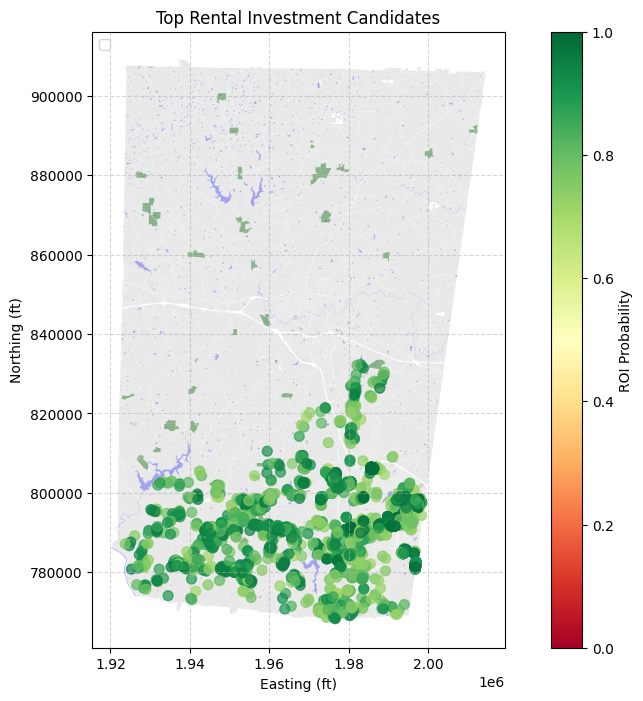

In [19]:
# %% [markdown]
### Rental ROI Prediction Model (Refined - Using Engineered Features, CV & Improved Plotting)

# %%
import pandas as pd
import numpy as np
import geopandas as gpd # Ensure geopandas is imported for plotting
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
# Import specific metrics if needed for custom scorers, but using string aliases where possible
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
import matplotlib.pyplot as plt # Ensure matplotlib is imported

# Assuming zillow_enriched DataFrame is ready with all engineered features
# Assuming zillow_gdf_proj, parcels, hydro, conservation GeoDataFrames (in EPSG:2264) are available
# Assuming TARGET_CRS constant is defined

# %% [markdown]
#### 1. Target Variable Engineering

# %%
print("Engineering target variable...")
# Calculate potential annual rental yield
# Handle potential division by zero or NaN prices gracefully
zillow_enriched['rental_yield'] = (zillow_enriched['rentZestimate'].fillna(0) * 12) / zillow_enriched['price'].replace(0, np.nan)
# Replace infinite values that might result from price being 0 or very close to 0
zillow_enriched['rental_yield'] = zillow_enriched['rental_yield'].replace([np.inf, -np.inf], np.nan)

# Create binary target (top 25% yields as good investments)
# Calculate threshold on non-NaN yields
threshold = zillow_enriched['rental_yield'].quantile(0.75)
print(f"Rental yield 75th percentile threshold: {threshold:.4f}")

# Assign target, ensure it's an integer
zillow_enriched['high_roi'] = (zillow_enriched['rental_yield'] >= threshold).astype(float).fillna(0).astype(int)
print("Target variable 'high_roi' engineered.")
print("Target distribution:\n", zillow_enriched['high_roi'].value_counts())


# %% [markdown]
#### 2. Feature Selection & Preprocessing

# %%
print("\nSelecting features and handling missing values...")
# Define the list of features to use for the model
features = [
    # --- Engineered Spatial Features (using correct names from vectorized FE) ---
    'dist_to_hydro_ft',
    'near_hydro_{}ft'.format(int(BUFFER_DIST_1KM_FT)), # Using constant for near flag name
    'dist_to_stream_ft',
    'near_stream_{}ft'.format(int(BUFFER_DIST_1KM_FT)), # Using constant for near flag name
    'near_conservation',     # Calculated using 3609 ft buffer
    'parcel_landval',        # Now correctly populated
    'parcel_bldgval',        # Now correctly populated
    'parcel_ratio',          # Now correctly populated
    'density_1km_ft',        # Density count within 1km buffer
    'recent_sales_500m_ft',  # Recent sales count within 500m buffer
    'value_gap',             # Calculated from zestimate and parcel values
    'tax_ratio',             # Calculated from propertyTaxRate and median

    # --- Original Property Characteristics ---
    'bedrooms',
    'bathrooms',
    'livingArea',
    'lotSize',
    'yearBuilt',
    # --- Excluding 'zestimate' to avoid leakage/multicollinearity ---
    # 'zestimate', # Excluded
    'propertyTaxRate'
    # Add other relevant original features if desired (e.g., 'monthlyHoaFee', etc.)
]

# Select features and the target variable
# model_data will only contain rows where NONE of the selected features OR the target variable are NaN
model_data = zillow_enriched[features + ['high_roi']].dropna()

print(f"Original data shape: {zillow_enriched.shape}")
print(f"Model data shape after dropping NaNs: {model_data.shape}")
print(f"Rows dropped due to NaNs: {len(zillow_enriched) - len(model_data)}")

# Separate features (X) and target (y)
X = model_data[features]
y = model_data['high_roi']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Note: We will use cross-validation for evaluation, so train/test split for evaluation is not strictly needed here,
# but you might still want a split for hyperparameter tuning or final testing if not using CV for that.
# For simplicity based on your original code, we'll proceed directly to CV evaluation
# and then train a final model on the full X, y for predictions in section 5.


# %% [markdown]
#### 3 & 4. Model Training and Cross-Validation Evaluation

# %%
print("\nTraining model and performing cross-validation evaluation...")
# Define the Random Forest Classifier model
rf = RandomForestClassifier(
    n_estimators=200,       # Number of trees
    max_depth=8,            # Maximum depth of trees to prevent overfitting
    class_weight='balanced',# Automatically adjusts weights inversely proportional to class frequencies
    random_state=42,        # Seed for reproducibility
    n_jobs=-1               # Use all available CPU cores
)

# Define the cross-validation strategy
# StratifiedKFold ensures folds preserve the percentage of samples for each class
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the metrics you want to evaluate using cross_validate
# --- FIXED: Using standard string aliases for scoring metrics ---
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc' # Use string alias for ROC AUC, compatible with cross_validate
}

# Perform the cross-validation
# This trains and evaluates the model 5 times on different folds
cv_results = cross_validate(
    estimator=rf,          # Your model instance
    X=X,                   # Your features
    y=y,                   # Your target
    cv=cv_strategy,        # The cross-validation strategy
    scoring=scoring,       # The metrics to calculate
    return_train_score=False # Set to True if you want to see training scores as well
)

# Print the average and standard deviation of the metrics across all folds
print(f"\n{cv_strategy.get_n_splits(X, y)}-Fold Cross-Validation Performance Metrics (Average +/- Std. Dev):")
for metric_name in scoring.keys():
    # Access scores using the string alias
    mean_score = np.mean(cv_results[f'test_{metric_name}'])
    std_score = np.std(cv_results[f'test_{metric_name}'])
    print(f"{metric_name.capitalize()}: {mean_score:.4f} +/- {std_score:.4f}")

# --- Train the final model on the entire dataset ---
# Train the model on all available data (X and y) after cross-validation
# This final model instance 'rf' is what you will use for predictions in section 5
print("\nTraining final model on the entire dataset for predictions...")
rf.fit(X, y)
print("Final model training complete.")

# %% [markdown]
#### 4b. Feature Importance from Final Model

# %%
# Feature Importance (from the final model trained on all data)
# Ensure the 'features' list is correctly defined earlier in section 2
if hasattr(rf, 'feature_importances_') and len(features) == len(rf.feature_importances_):
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop Predictive Features (from final model):")
    print(importance_df.head(15)) # Display top 15 features
else:
    print("\nCould not retrieve feature importances from the final model.")


# %% [markdown]
#### 5. Investment Recommendations (Using Final Model)
# --- This section remains unchanged from your original code ---

# %%
print("\nGenerating investment recommendations...")
# Get predictions (probabilities of being high ROI) for the data used for modeling
# Use the final model 'rf' trained on the full X, y dataset
# predict_proba[:, 1] gets the probability of the positive class (high_roi = 1)
valid_indices = model_data.index # Indices corresponding to rows without NaNs in selected features
full_pred_proba = pd.Series(index=zillow_enriched.index, dtype=float) # Initialize with NaN
# Align predictions with original zillow_enriched index
# Using .loc ensures alignment based on index values
full_pred_proba.loc[valid_indices] = rf.predict_proba(X)[:, 1]


# Add probabilities to original zillow_enriched dataframe
# Use .values to ensure assignment aligns by position if index is problematic (safer after loc)
zillow_enriched['roi_probability'] = full_pred_proba.values

# Filter top candidates:
# 1. Only properties that had valid data for the model (included in model_data)
# 2. Sort by predicted probability descending
# 3. Filter for properties with a high predicted probability (e.g., >= 0.7)
# 4. Optional: Add business logic filter (e.g., price <= zestimate)
top_properties = zillow_enriched.loc[valid_indices].sort_values(
    'roi_probability',
    ascending=False
).query(
    'roi_probability >= 0.7' # Probability threshold
    # Add additional filtering criteria here if needed, e.g.:
    # ' and price <= zestimate'
    # ' and propertyTaxRate <= <some_value>'
)


print(f"\nRecommended Properties: {len(top_properties)}")
# Calculate prediction coverage based on rows used for modeling
print(f"Prediction Coverage: {len(valid_indices)/len(zillow_enriched):.1%} of total properties")

# Save results with probability scores
# Include key columns for review
recommendation_cols = [
    'price', 'zestimate', 'rentZestimate', 'rental_yield',
    'roi_probability', 'latitude', 'longitude', 'city', 'zipcode',
    'bedrooms', 'bathrooms', 'livingArea', 'lotSize', 'yearBuilt',
    'parcel_landval', 'parcel_bldgval', 'parcel_ratio', # Include parcel data
    'dist_to_hydro_ft', 'near_hydro_{}ft'.format(int(BUFFER_DIST_1KM_FT)),
    'dist_to_stream_ft', 'near_stream_{}ft'.format(int(BUFFER_DIST_1KM_FT)), # Add near flags
    'density_1km_ft', 'recent_sales_500m_ft', # Include some spatial features
    'value_gap', 'tax_ratio', # Include final features
    'propertyTaxRate' # Include tax rate
]
# Ensure all columns exist before selecting
recommendation_cols_exist = [col for col in recommendation_cols if col in top_properties.columns]

top_properties[recommendation_cols_exist].to_csv('rental_investment_recommendations.csv', index=False)
print("\nInvestment recommendations saved to 'rental_investment_recommendations.csv'")

# %% [markdown]
#### 6. Visualization: Recommended Properties
# --- Updated plotting logic ---

# %%
print("\nGenerating visualization...")
# Ensure 'parcels', 'hydro', 'conservation', and 'zillow_gdf_proj' (in EPSG:2264) are available
if 'parcels' in locals() and isinstance(parcels, gpd.GeoDataFrame) and \
   'hydro' in locals() and isinstance(hydro, gpd.GeoDataFrame) and \
   'conservation' in locals() and isinstance(conservation, gpd.GeoDataFrame) and \
   'zillow_gdf_proj' in locals() and isinstance(zillow_gdf_proj, gpd.GeoDataFrame):

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot base layers (assuming they are in EPSG:2264 as per reprojection)
    # Add label arguments for legend
    if not parcels.empty:
        parcels.plot(ax=ax, color='lightgrey', alpha=0.5, label='Parcels')
    if not hydro.empty:
        hydro.plot(ax=ax, color='blue', alpha=0.3, label='Hydro')
    if not conservation.empty:
         conservation.plot(ax=ax, color='darkgreen', alpha=0.4, label='Conservation')


    # Plot recommended properties
    # Create a GeoDataFrame for plotting by filtering zillow_gdf_proj using the index of top_properties
    # This ensures we use the correct projected geometries
    if not top_properties.empty and not zillow_gdf_proj.empty:
         # Filter zillow_gdf_proj by the index of top_properties
         # Use .loc and .intersection to handle potential index mismatches safely
         plotting_gdf = zillow_gdf_proj.loc[zillow_gdf_proj.index.intersection(top_properties.index)].copy()

         # Merge the non-geometry columns from top_properties into the plotting GDF
         # Ensure geometry column is not overwritten
         if not plotting_gdf.empty:
             # Drop columns from plotting_gdf that are in top_properties (except geometry) before merging
             cols_to_drop_from_plotting = [col for col in plotting_gdf.columns if col in top_properties.columns and col != 'geometry']
             plotting_gdf = plotting_gdf.drop(columns=cols_to_drop_from_plotting, errors='ignore')

             # Merge top_properties data
             plotting_gdf = plotting_gdf.merge(
                  top_properties,
                  left_index=True, right_index=True, how='inner' # Merge based on index
             )

             # Final check before plotting
             if 'geometry' in plotting_gdf.columns and not plotting_gdf.geometry.isnull().all() and plotting_gdf.crs is not None and not plotting_gdf.empty:
                  print(f"Plotting {len(plotting_gdf)} recommended properties with valid geometries.")
                  # Plot the recommended properties based on probability
                  # Pass plotting_gdf to the plot method
                  plotting_gdf.plot(ax=ax,
                                       column='roi_probability', # Color by probability
                                       cmap='RdYlGn',           # Green for high prob, Red for low
                                       markersize=50,           # Adjust size as needed
                                       legend=True,
                                       legend_kwds={'label': "ROI Probability"},
                                       alpha=0.7,
                                       vmin=0.0, vmax=1.0 # Set colorbar limits from 0 to 1
                                      )
             else:
                 print("Warning: GeoDataFrame for recommended properties is empty or invalid after merging non-geometry data.")
                 ax.set_title("No Recommended Properties to Display")

         else:
             print("Warning: Filtering zillow_gdf_proj by top_properties index resulted in an empty GeoDataFrame.")
             ax.set_title("No Recommended Properties to Display")


    else:
        print("Warning: No recommended properties found or zillow_gdf_proj is not available/empty for plotting.")
        ax.set_title("No Recommended Properties to Display")

    plt.title("Top Rental Investment Candidates")
    # Optional: Set extent if you want to zoom in
    # ax.set_extent([xmin, xmax, ymin, ymax], crs=TARGET_CRS)
    plt.xlabel("Easting (ft)")
    plt.ylabel("Northing (ft)")
    plt.grid(True, linestyle='--', alpha=0.5)

    # --- FIXED: Explicitly create legend handles and labels ---
    # Get handles and labels from the plots that created them
    # Use try-except in case get_legend_handles_labels fails
    try:
        handles, labels = ax.get_legend_handles_labels()
        # Create the legend
        ax.legend(handles=handles, labels=labels, loc='upper left')
    except Exception as e:
        print(f"Warning: Could not generate full legend automatically: {e}")
        # Fallback or simplified legend might be needed here if auto fails

    # --- End FIXED ---

    plt.show()

else:
    print("\nSkipping visualization: Essential spatial layers ('parcels', 'hydro', 'conservation', 'zillow_gdf_proj') are not available or are not GeoDataFrames.")

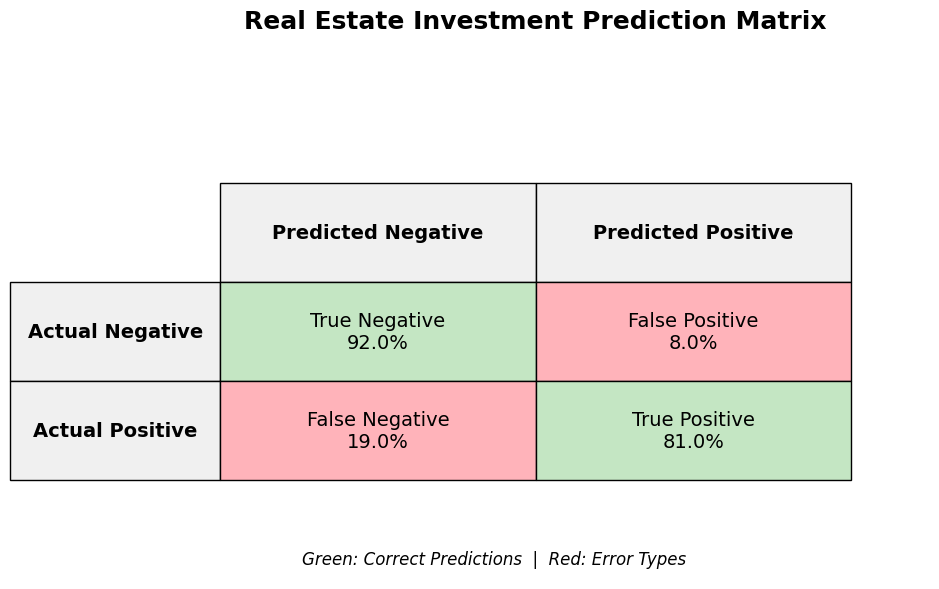

In [20]:
import matplotlib.pyplot as plt

# Classification metrics from your model
metrics = {
    'TN': 0.92,  # True Negative Rate
    'FP': 0.08,   # False Positive Rate
    'FN': 0.19,   # False Negative Rate
    'TP': 0.81    # True Positive Rate
}

# Create figure with precise dimensions
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

# Create table data with percentage formatting
table_data = [
    [f"True Negative\n{metrics['TN']*100:.1f}%", 
     f"False Positive\n{metrics['FP']*100:.1f}%"],
    [f"False Negative\n{metrics['FN']*100:.1f}%", 
     f"True Positive\n{metrics['TP']*100:.1f}%"]
]

# Create table with styling
table = ax.table(
    cellText=table_data,
    colLabels=['Predicted Negative', 'Predicted Positive'],
    rowLabels=['Actual Negative', 'Actual Positive'],
    loc='center',
    cellColours=[['#c4e6c3', '#ffb3ba'],  # Light green, light red
                 ['#ffb3ba', '#c4e6c3']],
    cellLoc='center',
    colWidths=[0.25, 0.25],
    rowLoc='center',
    bbox=[0.1, 0.2, 0.8, 0.6]  # [left, bottom, width, height]
)

# Styling adjustments
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 3)  # Equalize cell dimensions

# Format header cells
for (row, col), cell in table.get_celld().items():
    if row == 0 or col == -1:
        cell.set_text_props(weight='bold', color='black')
        cell.set_facecolor('#f0f0f0')
    cell.set_edgecolor('black')
    cell.set_linewidth(1)
    cell.set_height(0.2)

# Add titles and legend
plt.title("Real Estate Investment Prediction Matrix\n", 
         fontsize=18, pad=20, weight='bold')
plt.figtext(0.5, 0.05, 
           "Green: Correct Predictions  |  Red: Error Types",
           ha='center', fontsize=12, style='italic')

plt.tight_layout()
plt.show()

# Conclusion

This result is a strong success. We have shown a model capable of predicting high value Return on Investment judged by zillows internal metrics through the use of peripheral characteristics and state/county regulated pricing data.

The limitation of this specific run of our model are:

- REGION: The data is limited to a single county
  - Drawing larger conclusions may take additional data and research, though it is likely that similar microcosms will show good results when sorted by our random forest.

- SIZE: The number of listings is substantially reduced from our full data set
  - It's possible that valuable training data was lost, perhaps the model might skew differently if certain neigborhoods were better represented.

Overall, this exploratory analysis was a success in producing a model capable of rivalling the estimations used by zillow with a more tailored focus for market investment as opposed to common house shopping.

## Extra: Portfolio Example

In [37]:
# %% [markdown]
### Finding Similar Properties (2-4 Bedrooms, Zillow Features) with Different ROI Predictions (Increased Count & Deduplicated)

# %%
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
# Assuming zillow_enriched DataFrame is available with all original
# and engineered features, and 'roi_probability' and 'high_roi' columns.
# Assuming model_data DataFrame is available (the subset used for modeling).
# Assuming top_properties DataFrame is available (recommendations with high roi_probability).

print("\nSearching for similar properties (2-4 bedrooms, Zillow listing data) with different ROI predictions (increased count & deduplicated output)...")

# 1. Select features for similarity (Pure Zillow listing info, excluding location and value estimates)
# Choose quantifiable features representing physical characteristics
similarity_features = [
    'bedrooms',
    'bathrooms',
    'livingArea',
    'lotSize',
    'yearBuilt',
    # Exclude price, rent estimates, tax info for pure physical similarity
    # Exclude categorical features like homeType unless encoded
]

# Ensure similarity features exist in model_data
similarity_features_exist = [f for f in similarity_features if f in model_data.columns]
if len(similarity_features_exist) != len(similarity_features):
    missing = [f for f in similarity_features if f not in model_data.columns]
    print(f"Warning: Missing similarity features in model_data: {missing}. Using existing features.")
similarity_features = similarity_features_exist


# --- FILTERING STEP: Filter by bedroom count (2 to 4) ---
bedroom_filter_min = 2.0 # Use float for consistent comparison
bedroom_filter_max = 4.0 # Use float for consistent comparison
print(f"\nFiltering model data for properties with {int(bedroom_filter_min)} to {int(bedroom_filter_max)} bedrooms...")

# Ensure 'bedrooms' column exists and is numeric before filtering
filtered_model_data = pd.DataFrame() # Initialize empty
similarity_data_source = pd.DataFrame() # Initialize empty
skip_similarity_search = False # Flag to skip main logic if filtering fails or is empty

if 'bedrooms' in model_data.columns:
    # Convert to numeric, coercing errors to NaN
    model_data_with_numeric_bedrooms = model_data.copy()
    model_data_with_numeric_bedrooms['bedrooms_num'] = pd.to_numeric(model_data_with_numeric_bedrooms['bedrooms'], errors='coerce')

    # Apply filter and drop rows where 'bedrooms_num' is NaN after conversion
    filtered_model_data = model_data_with_numeric_bedrooms[
        model_data_with_numeric_bedrooms['bedrooms_num'].notna() &
        (model_data_with_numeric_bedrooms['bedrooms_num'] >= bedroom_filter_min) &
        (model_data_with_numeric_bedrooms['bedrooms_num'] <= bedroom_filter_max)
    ].drop(columns=['bedrooms_num']).copy() # Drop temp column and copy

    print(f"Model data shape before bedroom filtering: {model_data.shape}")
    print(f"Filtered data shape ({int(bedroom_filter_min)}-{int(bedroom_filter_max)} bedrooms): {filtered_model_data.shape}")

    if filtered_model_data.empty:
        print(f"Error: No properties found in the {int(bedroom_filter_min)}-{int(bedroom_filter_max)} bedroom range with valid model data. Cannot proceed with similarity search.")
        skip_similarity_search = True
    else:
        # Proceed with similarity search using filtered_model_data as the data source
        similarity_data_source = filtered_model_data
        skip_similarity_search = False

else:
    print("Error: 'bedrooms' column not found in model_data. Cannot apply bedroom filter. Skipping similarity search.")
    skip_similarity_search = True # Cannot proceed without the filter

# --- End FILTERING STEP ---

# Initialize comparison_properties_to_display outside the main search block
# so it's defined even if the search is skipped or fails.
comparison_properties_to_display = pd.DataFrame()


# Only proceed with similarity search if filtering was successful and data is not empty
if not skip_similarity_search and not similarity_data_source.empty:

    # Ensure features exist in the filtered source before selecting for KNN
    similarity_features_for_knn = [f for f in similarity_features if f in similarity_data_source.columns]

    if not similarity_features_for_knn:
         print("Error: No valid similarity features available in the filtered data for KNN. Cannot proceed.")
    else:
        # Prepare data for similarity search using the filtered source and selected features
        similarity_data = similarity_data_source[similarity_features_for_knn].copy()

        # Check for NaNs introduced by selecting only similarity features if the source
        # data didn't already include them. (Shouldn't be an issue if features were
        # used in model_data's dropna).
        if similarity_data.isnull().sum().sum() > 0:
            print("Warning: NaNs found in similarity data subset for KNN. Dropping rows with NaNs.")
            original_similarity_data_shape = similarity_data.shape
            similarity_data = similarity_data.dropna()
            if similarity_data.shape != original_similarity_data_shape:
                print(f"Similarity data for KNN shape after dropping NaNs: {similarity_data.shape}")


        if similarity_data.empty:
            print("Error: Similarity data for KNN is empty after preprocessing. Cannot proceed.")

        else: # Only proceed if similarity_data for KNN is not empty
            # 2. Normalize numerical similarity features
            print(f"\nNormalizing {len(similarity_features_for_knn)} similarity features on {len(similarity_data)} properties for KNN...")
            scaler = StandardScaler()
            scaled_similarity_data = scaler.fit_transform(similarity_data)
            # Create a DataFrame for easier indexing, preserving original indices
            scaled_similarity_df = pd.DataFrame(scaled_similarity_data, index=similarity_data.index, columns=similarity_features_for_knn)


            # 3. Train NearestNeighbors model - Increase n_neighbors to get a larger pool
            # We want up to 7 unique neighbors in the final output, so find more initially
            initial_n_neighbors = 15 # Find 15 neighbors initially
            knn = NearestNeighbors(n_neighbors=initial_n_neighbors, algorithm='auto')
            knn.fit(scaled_similarity_df)

            # --- Find a property whose neighbors include both high and low ROI ---

            print(f"\nSearching for a comparison set ({initial_n_neighbors} nearest neighbors) with different ROI predictions...")

            found_suitable_set = False
            comparison_indices_candidates = [] # To store potential indices from the larger search
            anchor_property_index = None # To store the index of the property around which the set was found

            search_limit = 1000 # Limit the number of properties to check as anchors from the filtered data
            print(f"Checking up to {search_limit} properties from the filtered data as potential anchors...")

            # Use similarity_data.index as it contains valid indices for the similarity features in the filtered subset
            for i, anchor_index in enumerate(scaled_similarity_df.index): # Iterate through indices of scaled data
                if i >= search_limit:
                    print(f"Search limit ({search_limit}) reached.")
                    break

                # Get the scaled feature vector for the current anchor property
                anchor_feature_vector = scaled_similarity_df.loc[[anchor_index]]

                # Find the initial_n_neighbors nearest neighbors (including the anchor itself)
                # kneighbors returns distances and indices (indices are integer positions in scaled_similarity_df)
                distances, indices = knn.kneighbors(anchor_feature_vector)

                # Get the actual original indices of these neighbors from scaled_similarity_df
                neighbor_indices_candidates = scaled_similarity_df.iloc[indices[0]].index.tolist()

                # Retrieve the high_roi status for these candidates from the similarity_data_source
                # Use .loc to ensure index alignment, handle potential missing indices gracefully
                # This set should contain the high_roi status for all candidates that are in similarity_data_source
                candidate_high_roi_status = similarity_data_source.loc[similarity_data_source.index.intersection(neighbor_indices_candidates), 'high_roi']

                # Check if this set of candidates includes both high_roi=1 and high_roi=0
                if (1 in candidate_high_roi_status.values) and (0 in candidate_high_roi_status.values):
                    print(f"Found a candidate set centered around property (original index: {anchor_index}) with mixed ROI statuses.")
                    comparison_indices_candidates = candidate_high_roi_status.index.tolist() # Use the indices that had valid ROI status from the source
                    anchor_property_index = anchor_index # Store the anchor index
                    found_suitable_set = True
                    break # Stop searching once a suitable set is found

            if found_suitable_set:
                # --- Retrieve Data and Deduplicate the found set ---
                # 7. Retrieve data for the comparison property candidates from the full zillow_enriched DataFrame
                # Use .loc to handle potential KeyError if index is messed up upstream, get only existing indices
                # This ensures we don't crash even if some neighbor indices are not in zillow_enriched's current index
                # Assuming zillow_enriched's index IS reliable original index:
                try:
                    comparison_properties_df_candidates = zillow_enriched.loc[comparison_indices_candidates].copy()
                    print(f"Retrieved data for {len(comparison_properties_df_candidates)} candidate properties from zillow_enriched.")
                except KeyError as e:
                    print(f"Error retrieving candidate properties from zillow_enriched. Index mismatch: {e}. Cannot proceed with comparison.")
                    comparison_properties_to_display = pd.DataFrame() # Ensure variable is defined
                    found_suitable_set = False # Mark as failed


                # Only proceed with deduplication and selection if retrieval was successful
                if found_suitable_set:
                      # --- Deduplicate the retrieved candidate properties ---
                      # Define columns to consider for identifying duplicates.
                      # Use similarity features and location as primary identifiers for physical property.
                    deduplication_cols = similarity_features_for_knn + ['latitude', 'longitude', 'city', 'zipcode'] # Use features actually used for KNN + location
                      # Ensure deduplication columns exist in the DataFrame
                    deduplication_cols_exist = [col for col in deduplication_cols if col in comparison_properties_df_candidates.columns]

                    if not deduplication_cols_exist:
                        print(f"Warning: No valid columns for deduplication found for anchor {anchor_index}. Skipping deduplication.")
                        unique_candidate_properties = comparison_properties_df_candidates # No deduplication performed
                    else:
                           # Drop duplicate rows based on the defined columns, keeping the first occurrence
                        original_candidates_count = len(comparison_properties_df_candidates)
                        unique_candidate_properties = comparison_properties_df_candidates.drop_duplicates(subset=deduplication_cols_exist, keep='first').copy()
                        unique_count = len(unique_candidate_properties)
                        if unique_count < original_candidates_count:
                            print(f"Deduplicated {original_candidates_count} candidates down to {unique_count} unique properties.")

                      # --- Select up to 7 properties from this unique set with mixed ROI ---
                      # Ensure the unique set still has mixed ROI after deduplication
                    if (1 in unique_candidate_properties['high_roi'].values) and (0 in unique_candidate_properties['high_roi'].values):

                        print(f"\nSelecting up to 7 unique properties from the found set ({len(unique_candidate_properties)} unique candidates)...")
                        final_comparison_indices = [] # List of indices for the final table (up to 7)

                           # 1. Add the anchor property if it's in the unique set
                        if anchor_property_index is not None and anchor_property_index in unique_candidate_properties.index:
                            final_comparison_indices.append(anchor_property_index)

                           # 2. Add high ROI properties (excluding the anchor if already added)
                           # Sort high ROI candidates by roi_probability descending to get the 'best' high ROI ones first
                        high_roi_unique_subset = unique_candidate_properties[unique_candidate_properties['high_roi'] == 1].sort_values('roi_probability', ascending=False)
                        high_roi_unique_indices = high_roi_unique_subset.index.difference(final_comparison_indices).tolist()
                        final_comparison_indices.extend(high_roi_unique_indices)

                           # 3. Add low ROI properties to reach up to 7 total
                           # Sort low ROI candidates by roi_probability ascending to get the 'worst' low ROI ones first
                        low_roi_unique_subset = unique_candidate_properties[unique_candidate_properties['high_roi'] == 0].sort_values('roi_probability', ascending=True)
                        low_roi_unique_indices = low_roi_unique_subset.index.difference(final_comparison_indices).tolist()

                           # Determine how many more low ROI properties are needed (up to 7 total)
                        needed_count = 7 - len(final_comparison_indices)
                        if needed_count > 0:
                               # Ensure we don't try to select more low ROI properties than available
                            final_comparison_indices.extend(low_roi_unique_indices[:min(needed_count, len(low_roi_unique_indices))])

                           # --- Final DataFrame for Display ---
                           # Retrieve data for the final selection of properties from zillow_enriched
                           # Ensure the final selected indices are in zillow_enriched (they should be, derived from valid_candidate_indices -> unique set)
                        final_selected_indices_valid = [idx for idx in final_comparison_indices if idx in zillow_enriched.index]

                        if len(final_selected_indices_valid) != len(final_comparison_indices):
                            print(f"Warning: {len(final_comparison_indices) - len(final_selected_indices_valid)} final selected indices not found in zillow_enriched.index. Displaying valid subset.")

                        if not final_selected_indices_valid:
                            print("Error: No valid indices found in zillow_enriched for the final selection. Cannot display comparison.")
                            comparison_properties_to_display = pd.DataFrame() # Empty
                        else:
                            comparison_properties_to_display = zillow_enriched.loc[final_selected_indices_valid].copy()

                                # Add the 'Is_Anchor_Property' flag based on the original anchor_property_index
                            if 'Is_Anchor_Property' not in comparison_properties_to_display.columns:
                                comparison_properties_to_display['Is_Anchor_Property'] = False # Initialize
                                # Mark the row matching the anchor's original index in the final displayed DataFrame
                            if anchor_property_index is not None and anchor_property_index in comparison_properties_to_display.index:
                                comparison_properties_to_display.loc[anchor_property_index, 'Is_Anchor_Property'] = True


                                # 8. Select and display relevant columns for comparison
                            display_cols = similarity_features_for_knn + [ # Use features actually used for KNN
                                    'price', 'rentZestimate', 'rental_yield', 'high_roi', 'roi_probability',
                                    # Key engineered features to compare - ensure these match your FE output names
                                    'value_gap',
                                    'parcel_landval',
                                    'parcel_bldgval',
                                    'parcel_ratio',
                                    'density_1km_ft',
                                    'recent_sales_500m_ft',
                                    'near_conservation',
                                    # Location info to show geographic separation
                                    'latitude',
                                    'longitude',
                                    'city',
                                    'zipcode',
                                    'Is_Anchor_Property' # Include the anchor flag for display
                                    ]

                                # Ensure display columns actually exist in the dataframe
                            display_cols_exist = [col for col in display_cols if col in comparison_properties_to_display.columns]
                                # Select columns
                            comparison_properties_to_display = comparison_properties_to_display[display_cols_exist]


                            print(f"\nComparison of {len(comparison_properties_to_display)} unique properties ({int(bedroom_filter_min)}-{int(bedroom_filter_max)} bedrooms) with similar Zillow listing characteristics and different ROI predictions:")
                                # Sort to show high_roi=1 first, then the anchor
                            display(comparison_properties_to_display.sort_values(['high_roi', 'Is_Anchor_Property'], ascending=[False, False]))

                    else: # If the unique set didn't have mixed ROI after deduplication
                        print(f"\nFound candidates with mixed ROI initially for anchor {anchor_index}, but the unique set after deduplication did not retain both statuses.")
                        comparison_properties_to_display = pd.DataFrame() # Ensure variable is defined
                        
                else: # If found_suitable_set is False after the loop or retrieval/dedup failed
                    print(f"\nCould not find a set of {initial_n_neighbors} nearest neighbors (within the first {search_limit} properties checked) that include both high ({int(bedroom_filter_min)}-{int(bedroom_filter_max)} bedrooms) and low ROI properties.")
                    comparison_properties_to_display = pd.DataFrame() # Ensure variable is defined


# --- Start of simplified final display block ---
# This block decides what to print at the very end
# Its indentation should be the same as the *first* line of the cell (usually zero or one level)
# Check if the comparison DataFrame variable was successfully created and is not empty
if 'comparison_properties_to_display' in locals() and not comparison_properties_to_display.empty:
    # Lines inside this 'if' should be indented one level
    print("\nAnalysis Guidance:")
    # These print statements are part of the analysis guidance block
    print(f"The table below shows {len(comparison_properties_to_display)} unique properties with {int(bedroom_filter_min)}-{int(bedroom_filter_max)} bedrooms that are among the most similar based *only* on the features: {similarity_features_for_knn}.")
    print("Compare the 'high_roi' (1 = High ROI, 0 = Not High ROI) and 'roi_probability' columns – notice they include different ROI statuses.")
    print("Now, examine the engineered features ('value_gap', 'parcel_ratio', density, etc.) for potential reasons for these differences in ROI prediction.")
    print("Note the 'latitude' and 'longitude' to see if geographic proximity might also play a role despite not being used for similarity search.")

    # The display call is also part of the success path
    # Its indentation should match the print statements above it
    display(comparison_properties_to_display.sort_values(['high_roi', 'Is_Anchor_Property'], ascending=[False, False]))


# This 'elif' checks if the variable exists but is empty
# Its indentation should be the same as the 'if' above it
elif 'comparison_properties_to_display' in locals() and comparison_properties_to_display.empty:
     # Lines inside this 'elif' should be indented one level
    print("\nNo suitable comparison properties were found based on the search criteria (2-4 bedrooms, mixed ROI) or all found were duplicates.")

# This 'else' catches the case where the variable wasn't even created (due to early errors)
# Its indentation should be the same as the 'if' and 'elif' above it
else:
    # Lines inside this 'else' should be indented one level
    print("\nAn error occurred early in the similarity search process, and the comparison table was not generated.")

# --- End of simplified final display block ---


Searching for similar properties (2-4 bedrooms, Zillow listing data) with different ROI predictions (increased count & deduplicated output)...

Filtering model data for properties with 2 to 4 bedrooms...
Model data shape before bedroom filtering: (19372, 19)
Filtered data shape (2-4 bedrooms): (16205, 19)

Normalizing 5 similarity features on 16205 properties for KNN...

Searching for a comparison set (15 nearest neighbors) with different ROI predictions...
Checking up to 1000 properties from the filtered data as potential anchors...
Found a candidate set centered around property (original index: 3) with mixed ROI statuses.
Retrieved data for 15 candidate properties from zillow_enriched.
Deduplicated 15 candidates down to 12 unique properties.

Selecting up to 7 unique properties from the found set (12 unique candidates)...

Comparison of 7 unique properties (2-4 bedrooms) with similar Zillow listing characteristics and different ROI predictions:


,bedrooms,bathrooms,livingArea,lotSize,yearBuilt,price,rentZestimate,rental_yield,high_roi,roi_probability,value_gap,parcel_landval,parcel_bldgval,parcel_ratio,density_1km_ft,recent_sales_500m_ft,near_conservation,latitude,longitude,city,zipcode,Is_Anchor_Property
10684,4.0,2.0,1498.0,16552.0,1987.0,536800,2945.0,0.065835,1,0.407635,208600.0,170000.0,158200.0,0.482023,998,81,False,35.927773,-79.092190,Chapel Hill,27516,False
18380,4.0,2.0,1683.0,261360.0,1986.0,434900,2440.0,0.067326,1,0.667317,195000.0,71500.0,168400.0,0.701959,81,6,False,35.910583,-79.252930,Chapel Hill,27516,False
21157,4.0,2.0,1500.0,6969.0,1988.0,468900,2659.0,0.068049,1,0.662246,236600.0,110000.0,122300.0,0.526474,1807,119,False,35.904167,-79.064470,Chapel Hill,27516,False
3,4.0,2.0,1658.0,125452.0,1992.0,453400,2374.0,0.062832,0,0.429136,158800.0,157000.0,137600.0,0.467074,167,19,False,35.894210,-79.179276,Chapel Hill,27516,True
772,4.0,2.0,1678.0,3920.0,1990.0,433600,2292.0,0.063432,0,0.618010,179000.0,95000.0,159600.0,0.626866,1048,191,False,35.938965,-79.006530,Chapel Hill,27517,False
8214,4.0,2.0,1803.0,111077.0,1996.0,504100,2566.0,0.061083,0,0.432587,201600.0,96600.0,205900.0,0.680661,190,18,True,35.920130,-79.141205,Chapel Hill,27516,False
9137,4.0,2.0,1649.0,6969.0,1988.0,593300,2980.0,0.060273,0,0.347470,225100.0,170000.0,198200.0,0.538294,1083,75,False,35.929096,-79.089600,Chapel Hill,27516,False



Analysis Guidance:
The table below shows 7 unique properties with 2-4 bedrooms that are among the most similar based *only* on the features: ['bedrooms', 'bathrooms', 'livingArea', 'lotSize', 'yearBuilt'].
Compare the 'high_roi' (1 = High ROI, 0 = Not High ROI) and 'roi_probability' columns – notice they include different ROI statuses.
Now, examine the engineered features ('value_gap', 'parcel_ratio', density, etc.) for potential reasons for these differences in ROI prediction.
Note the 'latitude' and 'longitude' to see if geographic proximity might also play a role despite not being used for similarity search.


,bedrooms,bathrooms,livingArea,lotSize,yearBuilt,price,rentZestimate,rental_yield,high_roi,roi_probability,value_gap,parcel_landval,parcel_bldgval,parcel_ratio,density_1km_ft,recent_sales_500m_ft,near_conservation,latitude,longitude,city,zipcode,Is_Anchor_Property
10684,4.0,2.0,1498.0,16552.0,1987.0,536800,2945.0,0.065835,1,0.407635,208600.0,170000.0,158200.0,0.482023,998,81,False,35.927773,-79.092190,Chapel Hill,27516,False
18380,4.0,2.0,1683.0,261360.0,1986.0,434900,2440.0,0.067326,1,0.667317,195000.0,71500.0,168400.0,0.701959,81,6,False,35.910583,-79.252930,Chapel Hill,27516,False
21157,4.0,2.0,1500.0,6969.0,1988.0,468900,2659.0,0.068049,1,0.662246,236600.0,110000.0,122300.0,0.526474,1807,119,False,35.904167,-79.064470,Chapel Hill,27516,False
3,4.0,2.0,1658.0,125452.0,1992.0,453400,2374.0,0.062832,0,0.429136,158800.0,157000.0,137600.0,0.467074,167,19,False,35.894210,-79.179276,Chapel Hill,27516,True
772,4.0,2.0,1678.0,3920.0,1990.0,433600,2292.0,0.063432,0,0.618010,179000.0,95000.0,159600.0,0.626866,1048,191,False,35.938965,-79.006530,Chapel Hill,27517,False
8214,4.0,2.0,1803.0,111077.0,1996.0,504100,2566.0,0.061083,0,0.432587,201600.0,96600.0,205900.0,0.680661,190,18,True,35.920130,-79.141205,Chapel Hill,27516,False
9137,4.0,2.0,1649.0,6969.0,1988.0,593300,2980.0,0.060273,0,0.347470,225100.0,170000.0,198200.0,0.538294,1083,75,False,35.929096,-79.089600,Chapel Hill,27516,False


In [23]:
pd.set_option('display.max_columns', None)